# AC209b - Final Project - Milestone 3

#### Project: Microbiome

**Group Members:** Dylan Randle, Joe Davison, Robbert Struyven, Simon Sebbagh

**GitHub:** Email simon_sebbagh@g.harvard.edu for access to the the GitHub repo, which contains far more detailed information than this report is able to.

[Ignite Talk](https://docs.google.com/presentation/d/e/2PACX-1vScqKZLgUrrTkOFIdl1ZM5d4yUBKA276Y1AORYqB1D7ZB_l3XDXiKqDbtJhTOAHyGSLdeaZZbXuz5mO/pub?start=false&loop=false&delayms=30000)


## Index 

1. [Preliminary EDA](#proposal) 
    1. [Literature Review](#lit_review)
   
2. [Visualization and Hypothesis Formation](#viz)

3. [Granger Causality](#granger)
    1. [Bayesian Optimization](#bayes_opt)
    2. [Fitting On Separate Mice](#sep_mice)
    3. [Pooling Within Groups](#pooling)
4. [Conclusion](#conclusion)

## Preliminary EDA <a name="proposal"></a>

In [1]:
import pickle

In [2]:
with open('mouse_set_1_data.pkl', 'rb') as f:
    mouse_1 = pickle.load(f)

with open('mouse_set_2_data.pkl', 'rb') as f:
    mouse_2 = pickle.load(f)

In [4]:
mouse_1.keys(), mouse_2.keys()

(dict_keys(['reads', 'qpcr', 'times', 'otu_taxonomy']),
 dict_keys(['reads', 'qpcr', 'times', 'otu_taxonomy']))

We have "reads", "qpcr", "times" and "otu_taxonomy".

In [5]:
mouse_1['reads'].keys(), mouse_2['reads'].keys()

(dict_keys(['2', '3', '4', '5']), dict_keys(['10', '6', '7', '8', '9']))

The healthy mice 2-5 are in `mouse_1` whereas the sick mice 6-10 are in `mouse_2`.

In [6]:
import pandas as pd

In [7]:
print('reads shape: {}'.format(mouse_1['reads']['2'].shape))
print(mouse_1['reads']['2'].head(5))

reads shape: (202, 75)
        0AM   0PM   1AM   1PM   2AM   2PM   3AM   3PM    4AM    4PM  ...   \
OTU_1  1094  3292  1744   193   468   974  1323  2854   7106   3949  ...    
OTU_2   180   825  1340  4501  9959  5564  2738  3069   2318   1229  ...    
OTU_3    10     8    10    27   117    28    44    50     77     49  ...    
OTU_4     3     0     9    32   205   254   196   361   1073    871  ...    
OTU_5     6    13   195   517   744  4703  5620  8592  11602  11978  ...    

       58PM  59AM  59PM  60AM  60PM     61     62    63  64AM  64PM  
OTU_1  3297  1415  1539  1641  6409   1477   1108   573   841   762  
OTU_2   100    25     0    80  5359     86    398   447  1265  1326  
OTU_3    10     6     3    20    15     26     11     4     7    24  
OTU_4  7318  6252  8405  9322  9061  12263  10940  6070  9832  8101  
OTU_5     1     0     0     0     4      1      1     8     1     0  

[5 rows x 75 columns]


In [8]:
def get_mouse_data(mouse_num, column):
    """ helper function to get mouse data """
    if mouse_num <= 5:
        # dict 1
        if column in['reads','qpcr']:
            return mouse_1[column][str(mouse_num)]
        else:
            return mouse_1[column]
    else:
        # dict 2
        if column in['reads','qpcr']:
            return mouse_2[column][str(mouse_num)]
        else:
            return mouse_2[column]

In [9]:
get_mouse_data(2, 'reads').head()

0AM   0PM   1AM   1PM   2AM   2PM   3AM   3PM    4AM    4PM  ...   \
OTU_1  1094  3292  1744   193   468   974  1323  2854   7106   3949  ...    
OTU_2   180   825  1340  4501  9959  5564  2738  3069   2318   1229  ...    
OTU_3    10     8    10    27   117    28    44    50     77     49  ...    
OTU_4     3     0     9    32   205   254   196   361   1073    871  ...    
OTU_5     6    13   195   517   744  4703  5620  8592  11602  11978  ...    

       58PM  59AM  59PM  60AM  60PM     61     62    63  64AM  64PM  
OTU_1  3297  1415  1539  1641  6409   1477   1108   573   841   762  
OTU_2   100    25     0    80  5359     86    398   447  1265  1326  
OTU_3    10     6     3    20    15     26     11     4     7    24  
OTU_4  7318  6252  8405  9322  9061  12263  10940  6070  9832  8101  
OTU_5     1     0     0     0     4      1      1     8     1     0  

[5 rows x 75 columns]

In [10]:
get_mouse_data(6, 'reads').head()

0AM    1AM    1PM    2AM    2PM    3AM    3PM    4AM    4PM      5  \
OTU_1  1048  33476  26834  22014  16204  16028  31380  11226  14789  16566   
OTU_2  1140   4714   7081   9512   8408   9939  20607   9503  11822  13296   
OTU_3    37     18     52   5232  11070  15833  21400  16949  16776  12645   
OTU_4    77      0      8      4      0      0      8      3      0     12   
OTU_5    93     10      4     35      8     20     15     11      7     15   

       ...     58PM   59AM   59PM   60AM   60PM     61     62     63  64AM  \
OTU_1  ...    19978  25303  13110  34878  30946  21687  25350  16198  8813   
OTU_2  ...    12025   6099   9515   1303   9133  13875   1624   8087  8362   
OTU_3  ...       13     14     11      2     19     43     13     20    12   
OTU_4  ...      339     26     63     59     15     68     31     16    29   
OTU_5  ...        0      0      0      2      0      2      5      3     9   

        64PM  
OTU_1   5041  
OTU_2  10075  
OTU_3      2  
OTU_4     37  
OTU_5      6  

[5 rows x 73 columns]

In [11]:
get_mouse_data(2, 'qpcr').head()

mean           std
0AM  8.724134e+06  6.029776e+05
0PM  3.674454e+07  1.388925e+07
1AM  2.554379e+11  9.572197e+10
1PM  8.266330e+09  2.948702e+09
2AM  8.107457e+09  4.296630e+09

In [12]:
get_mouse_data(6, 'qpcr').head()

mean           std
0AM  1.176631e+07  5.227645e+06
1AM  6.516426e+09  1.732993e+09
1PM  1.648246e+09  4.931391e+08
2AM  3.589292e+10  1.755669e+09
2PM  2.208925e+10  5.643835e+09

QPCR holds mean and std info (assuming related to total reads).

In [14]:
for m in range(2,11):
    print('\n===========')
    print('Mouse {}'.format(m))
    for c in ['reads', 'qpcr']:
        temp = get_mouse_data(m, c)
        print('Shape of {}: {}'.format(c, temp.shape))


Mouse 2
Shape of reads: (202, 75)
Shape of qpcr: (75, 2)

Mouse 3
Shape of reads: (202, 75)
Shape of qpcr: (75, 2)

Mouse 4
Shape of reads: (202, 75)
Shape of qpcr: (75, 2)

Mouse 5
Shape of reads: (202, 75)
Shape of qpcr: (75, 2)

Mouse 6
Shape of reads: (176, 73)
Shape of qpcr: (73, 2)

Mouse 7
Shape of reads: (176, 73)
Shape of qpcr: (73, 2)

Mouse 8
Shape of reads: (176, 73)
Shape of qpcr: (73, 2)

Mouse 9
Shape of reads: (176, 73)
Shape of qpcr: (73, 2)

Mouse 10
Shape of reads: (176, 73)
Shape of qpcr: (73, 2)


In [15]:
print('Num times mouse 1: {}'.format(len(mouse_1['times'])))
mouse_1['times'][0:10] # just a list

Num times mouse 1: 75


[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

In [16]:
print('Num times mouse 2: {}'.format(len(mouse_2['times'])))
mouse_2['times'][0:10]

Num times mouse 2: 73


[0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Note: The `times` are slightly different.

In [17]:
print('Mouse 1 OTU Taxonomy shape: {}'.format(mouse_1['otu_taxonomy'].shape))
mouse_1['otu_taxonomy'].head()

Mouse 1 OTU Taxonomy shape: (202, 7)


sequence   Kingdom  \
otuName                                                                
OTU_1    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  Bacteria   
OTU_2    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  Bacteria   
OTU_3    TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...  Bacteria   
OTU_4    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  Bacteria   
OTU_5    TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...  Bacteria   

                  Phylum             Class               Order  \
otuName                                                          
OTU_1      Bacteroidetes       Bacteroidia       Bacteroidales   
OTU_2      Bacteroidetes       Bacteroidia       Bacteroidales   
OTU_3    Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales   
OTU_4      Bacteroidetes       Bacteroidia       Bacteroidales   
OTU_5    Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales   

                      Family        Genus  
otuName                                    
OTU_1         Bacteroidaceae  Bacteroides  
OTU_2         Bacteroidaceae  Bacteroides  
OTU_3    Verrucomicrobiaceae  Akkermansia  
OTU_4         Bacteroidaceae  Bacteroides  
OTU_5    Verrucomicrobiaceae  Akkermansia

In [18]:
print('Mouse 2 OTU Taxonomy shape: {}'.format(mouse_2['otu_taxonomy'].shape))
mouse_2['otu_taxonomy'].head()

Mouse 2 OTU Taxonomy shape: (176, 7)


sequence   Kingdom  \
otuName                                                                
OTU_1    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  Bacteria   
OTU_2    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  Bacteria   
OTU_3    TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...  Bacteria   
OTU_4    TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  Bacteria   
OTU_5    TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...  Bacteria   

                  Phylum             Class               Order  \
otuName                                                          
OTU_1      Bacteroidetes       Bacteroidia       Bacteroidales   
OTU_2      Bacteroidetes       Bacteroidia       Bacteroidales   
OTU_3    Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales   
OTU_4      Bacteroidetes       Bacteroidia       Bacteroidales   
OTU_5    Verrucomicrobia  Verrucomicrobiae  Verrucomicrobiales   

                      Family        Genus  
otuName                                    
OTU_1         Bacteroidaceae  Bacteroides  
OTU_2         Bacteroidaceae  Bacteroides  
OTU_3    Verrucomicrobiaceae  Akkermansia  
OTU_4         Bacteroidaceae  Bacteroides  
OTU_5    Verrucomicrobiaceae  Akkermansia

`otu_taxonomy` holds dataframes that map the `otuName` to various info about the bug.

In [19]:
mouse2_reads=get_mouse_data(2,'reads')

In [20]:
mouse2_reads.head()

0AM   0PM   1AM   1PM   2AM   2PM   3AM   3PM    4AM    4PM  ...   \
OTU_1  1094  3292  1744   193   468   974  1323  2854   7106   3949  ...    
OTU_2   180   825  1340  4501  9959  5564  2738  3069   2318   1229  ...    
OTU_3    10     8    10    27   117    28    44    50     77     49  ...    
OTU_4     3     0     9    32   205   254   196   361   1073    871  ...    
OTU_5     6    13   195   517   744  4703  5620  8592  11602  11978  ...    

       58PM  59AM  59PM  60AM  60PM     61     62    63  64AM  64PM  
OTU_1  3297  1415  1539  1641  6409   1477   1108   573   841   762  
OTU_2   100    25     0    80  5359     86    398   447  1265  1326  
OTU_3    10     6     3    20    15     26     11     4     7    24  
OTU_4  7318  6252  8405  9322  9061  12263  10940  6070  9832  8101  
OTU_5     1     0     0     0     4      1      1     8     1     0  

[5 rows x 75 columns]

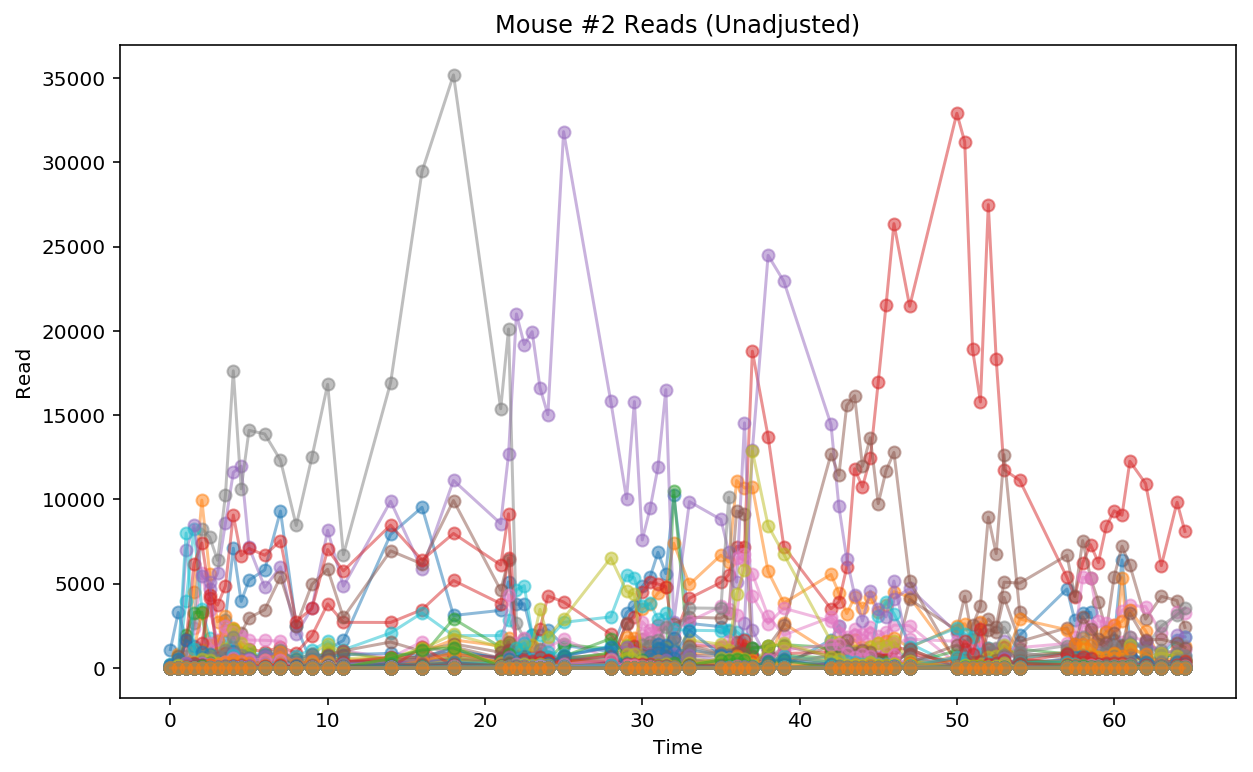

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
times_ = mouse_1['times']
plt.figure(figsize=(10,6))
for idx,row in mouse2_reads.iterrows():
    plt.plot(times_, row.values, '-o', alpha=0.5)
plt.title('Mouse #2 Reads (Unadjusted)')
plt.xlabel('Time')
plt.ylabel('Read');

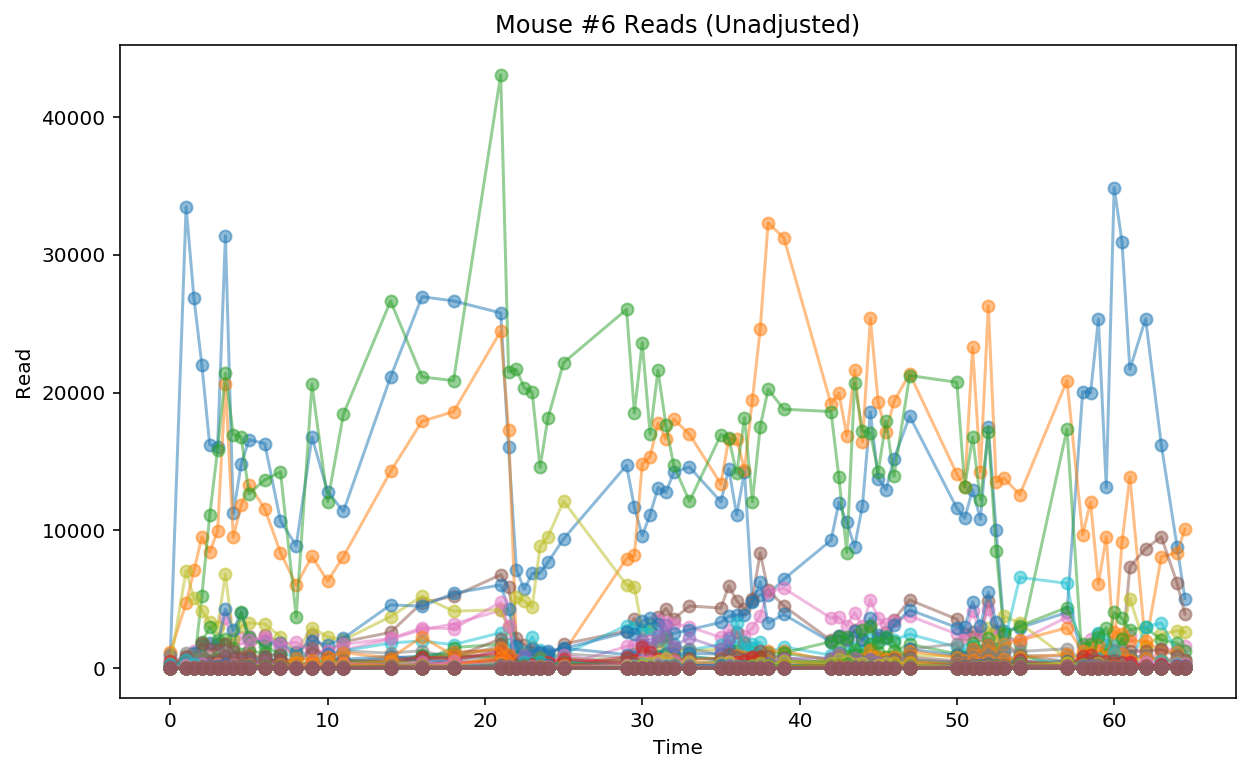

In [22]:
mouse6_reads = get_mouse_data(6, 'reads')
times_ = get_mouse_data(6, 'times')
plt.figure(figsize=(10,6))
for idx,row in mouse6_reads.iterrows():
    plt.plot(times_, row.values, '-o', alpha=0.5)
plt.title('Mouse #6 Reads (Unadjusted)')
plt.xlabel('Time')
plt.ylabel('Read');

In [23]:
## adjusting the reads
mouse2_qpcr = get_mouse_data(2, 'qpcr')
mouse2_qpcr.shape, mouse2_reads.shape

((75, 2), (202, 75))

In [24]:
display(mouse2_qpcr.head(2))
display(mouse2_reads.head(2))

mean           std
0AM  8.724134e+06  6.029776e+05
0PM  3.674454e+07  1.388925e+07

0AM   0PM   1AM   1PM   2AM   2PM   3AM   3PM   4AM   4PM  ...   58PM  \
OTU_1  1094  3292  1744   193   468   974  1323  2854  7106  3949  ...   3297   
OTU_2   180   825  1340  4501  9959  5564  2738  3069  2318  1229  ...    100   

       59AM  59PM  60AM  60PM    61    62   63  64AM  64PM  
OTU_1  1415  1539  1641  6409  1477  1108  573   841   762  
OTU_2    25     0    80  5359    86   398  447  1265  1326  

[2 rows x 75 columns]

In [25]:
mouse2_reads.shape, mouse2_qpcr.shape

((202, 75), (75, 2))

In [26]:
mouse3_reads, mouse3_qpcr = get_mouse_data(3, 'reads'), get_mouse_data(3, 'qpcr')

In [27]:
mouse3_reads.shape, mouse3_qpcr.shape

((202, 75), (75, 2))

In [28]:
mouse7_reads, mouse7_qpcr = get_mouse_data(7, 'reads'), get_mouse_data(7, 'qpcr')
mouse7_reads.shape, mouse7_qpcr.shape

((176, 73), (73, 2))

In [30]:
mouse7_reads.head()

0AM    1AM    1PM    2AM    2PM    3AM    3PM    4AM    4PM      5  \
OTU_1  1147  31882  33994  20313  23591  22837  17655  26871  16151  15231   
OTU_2  2793   2923   5021   7541  11733  11755  11658  18353  12455  11783   
OTU_3   205      7    114   9182  16640  11352  13721  22352  15658  10106   
OTU_4    79     13     19      7      5      0      0      0      0      0   
OTU_5   124      3     33     19      5     19     20     11      7      8   

       ...     58PM   59AM   59PM   60AM   60PM     61     62     63   64AM  \
OTU_1  ...    10389   2991   4597  12122  21545  21535  15914  16451  15190   
OTU_2  ...    15179  16188  25149   6451  15813   9545  10055   5080   8963   
OTU_3  ...     5165   4594   5829   3719   7135  12207  12073   9799   8880   
OTU_4  ...       36     46    123     59     12    115     27     38     70   
OTU_5  ...        0      0      0      1      0      0      2      9      0   

        64PM  
OTU_1  12481  
OTU_2   9130  
OTU_3  14526  
OTU_4     38  
OTU_5      1  

[5 rows x 73 columns]

In [31]:
import numpy as np
np.sum(mouse2_reads.values[:,0]), mouse2_qpcr.values[0,0]

(2929, 8724133.557309365)

####  Remarks:

All of the data seems to make sense. All of the dimensions line up. The most important thing to note is that `mouse_1` and `mouse_2` are fundamentally different experiments, taken from the same lab. That's why we have different `reads` dataframe shapes of `(202,75)` and `(176,73)` respectively. We really can't group these two together without taking this additional information into consideration.

One important point that was mentioned in the lecture is that the `reads` data is not quantitative, and only relatively relevant. To make across-time inferences legitimate, we must multiply the relative abundance by the total (found in `qpcr`).

### Literature Review and References <a name="lit_review"></a>
 1. Microbiome dynamics and temporal genetic data analysis
 2. [Microbiome and the origin of IBD](https://en.wikipedia.org/wiki/Inflammatory_bowel_disease#Microbiota)
 3. [Microbiome and the treatment of IBD](https://en.wikipedia.org/wiki/Inflammatory_bowel_disease#Microbiome)

----

#### 1. Microbiome dynamics and temporal genetic data analysis

*  **Many pitfalls in the microbiome analysis of temporal genetic data:** “The human gut microbiota is a very complex and dynamic ecosystem that plays a crucial role in health and well-being. Inferring microbial community structure and dynamics directly from time-resolved metagenomics data is key to understanding the community ecology and predicting its temporal behavior. Many methods have been proposed to perform the inference. Yet, as we point out in this review, there are several pitfalls along the way.
 -	Indeed, the uninformative temporal measurements and the compositional nature of the relative abundance data raise serious challenges in inference. 
 -	Moreover, the inference results can be largely distorted when only focusing on highly abundant species by ignoring or grouping low-abundance species. 
 -	Finally, the implicit assumptions in various regularization methods may not reflect reality. Those issues have to be seriously considered in ecological modeling of human gut microbiota.”
    - *REF: Cao HT, Gibson TE, Bashan A, Liu YY (February 2017). “Inferring human microbial dynamics from temporal metagenomics data: Pitfalls and lessons.” Bioessays. 2017 Feb;39(2). doi: 10.1002/bies.201600188. PMID: 28000336*

* **Longitudinal Prediction of the Infant Gut Microbiome with Dynamic Bayesian Networks:**  "Dynamic Bayesian Newtorks (DBNs) were able to identify important relationships between microbiome taxa and predict future changes in microbiome composition from measured or synthetic initial conditions. DBNs also provided likelihood estimates for sudden, dramatic shifts in microbiome composition, which may be useful in guiding further analysis of those samples."
    - *REF: McGeachie MJ, Sordillo JE, Gibson T, Weinstock GM, Liu YY, Gold DR, Weiss ST, Litonjua A. "Longitudinal Prediction of the Infant Gut Microbiome with Dynamic Bayesian Networks" (February 2016) Sci Rep. 2016 Feb 8;6:20359. doi: 10.1038/srep20359. PMID: 26853461*
    
* **Robust and Scalable Models of Microbiome Dynamics by specifying microbial interaction:**  "A new type of dynamical systems model for microbial dynamics based on what we term interaction modules, or learned clusters of latent variables with redundant interaction structure (reducing the expected number of interaction coefficients from O(n2) to O((logn)2)); a fully Bayesian formulation of the stochastic dynamical systems model that propagates measurement and latent state uncertainty throughout the model; and introduction of a temporally varying auxiliary variable technique to enable efficient inference by relaxing the hard non-negativity constraint on states."
    - *REF: Travis E. Gibson, Georg K. Gerber "Robust and Scalable Models of Microbiome Dynamics" (Submitted on 11 May 2018 (v1), last revised 8 Jun 2018 (this version, v2))*
    
* **Universality of gut microbial dynamics: after faecal microbiota transplantation we observe the same microbioal dynamics in different subjects:** “Notably, the universality of gut microbial dynamics is not observed in subjects with recurrent Clostridium difficile infection but is observed in the same set of subjects after faecal microbiota transplantation. These results fundamentally improve our understanding of the processes that shape human microbial ecosystems, and pave the way to designing general microbiome-based therapies.”
    - *REF: Bashan A, Gibson TE, Friedman J, Carey VJ, Weiss ST, Hohmann EL, Liu YY. (January 2016) “Universality of human microbial dynamics.” Nature. 2016 Jun 9;534(7606):259-62. doi: 10.1038/nature18301. PMID: 27279224*

* **Antibiotic effects on gut microbiota and metabolism are host dependent:** “Interactions of diet, gut microbiota, and host genetics play important roles in the development of obesity and insulin resistance.  Thus, changes in bile acid and inflammatory signaling, insulin resistance, and glucose metabolism driven by an HFD can be modified by antibiotic-induced changes in gut microbiota; however, these effects depend on important interactions with the host's genetic background and inflammatory potential.”
    - *REF: Fujisaka S, Ussar S, Clish C, Devkota S, Dreyfuss JM, Sakaguchi M, Soto M, Konishi M, Softic S, Altindis E, Li N, Gerber G, Bry L, Kahn CR. (December 2016) “Antibiotic effects on gut microbiota and metabolism are host dependent.” J Clin Invest. 2016 Dec 1;126(12):4430-4443. doi: 10.1172/JCI86674. PMID: 27775551*

----

#### 2. [Interesting references regarding microbiome and the etiology (cause/origin) of IBD](https://en.wikipedia.org/wiki/Inflammatory_bowel_disease#Microbiota)

* **Alterations in the gut microbiome may contribute to inflammatory gut diseases** as a result of microbial symbiosis and immunity, 
    - *REF: Mukhopadhya I, Hansen R, El-Omar EM, Hold GL (February 2012). "IBD-what role do Proteobacteria play?". Nature Reviews. Gastroenterology & Hepatology. 9 (4): 219–30. doi:10.1038/nrgastro.2012.14. PMID 22349170.*


* **IBD-affected individuals have been found to have 30–50 percent reduced biodiversity of commensal bacteria,** such as decreases in Firmicutes (namely Lachnospiraceae) and Bacteroidetes.
    - *REF: Leitner GC, Vogelsang H. Pharmacological- and non-pharmacological therapeutic approaches in inflammatory bowel disease in adults. World J Gastrointest Pharmacol Ther. 2016;7(1):5–20. doi:10.4292/wjgpt.v7.i1.5 PMID: 26855808*
    - *REF: Devkota S, Wang Y, Musch MW, Leone V, Fehlner-Peach H, Nadimpalli A, Antonopoulos DA, Jabri B, Chang EB. (2012 June) Dietary-fat-induced taurocholic acid promotes pathobiont expansion and colitis in Il10-/- mice. Nature. 5;487(7405):104-8. doi: 10.1038/nature11225. PMID: 22722865*

* **IBD-affected individuals are more likely to have been prescribed antibiotics in the 2–5 year period before their diagnosis than unaffected individuals.** 
    - *REF: Aroniadis OC, Brandt LJ (January 2013). "Fecal microbiota transplantation: past, present and future". Current Opinion in Gastroenterology. 29 (1): 79–84. doi:10.1097/ MOG.0b013e32835a4b3e. PMID 23041678.*


----

#### 3. [Interesting references regarding (change in low- or high-fat diet, antibiotics or fecal microbiota transplant) relating microbiome with treatment of IBD](https://en.wikipedia.org/wiki/Inflammatory_bowel_disease#Microbiome)

* **The enteral bacteria can be altered by environmental factors**, such as concentrated milk fats (a common ingredient of processed foods and confectionery) or oral medications such as antibiotics and oral iron preparations.
    - *REF: Kotanko P, Carter M, Levin NW (August 2006). "Intestinal bacterial microflora--a potential source of chronic inflammation in patients with chronic kidney disease". Nephrology, Dialysis, Transplantation. 21 (8): 2057–60. doi:10.1093/ndt/gfl281. PMID 16762961.*

* **Preliminary evidence of an infectious contribution to inflammatory bowel disease in some patients that may benefit from antibiotic therapy,** such as with rifaximin.
    - *REF: Lopetuso LR, Napoli M, Rizzatti G, Gasbarrini A (June 2018). "The intriguing role of Rifaximin in gut barrier chronic inflammation and in the treatment of Crohn's disease". Expert Opin Investig Drugs. 27 (6): 543–551. doi:10.1080/13543784.2018.1483333. PMID 29865875.*

* **Rifaximin could potentially be redefined as a gut environment modulator?** The evidence for a benefit of rifaximin is mostly limited to crohn’s disease with less convincing evidence supporting use in ulcerative colitis. Conclusion of the paper: “Accumulating evidence suggests that mechanisms of action of rifaximin in IBD may not be limited to direct bactericidal activity; therefore, rifaximin could potentially be redefined as a gut environment modulator.”
    - *REF: Sartor RB (January 2016). "Review article: the potential mechanisms of action of rifaximin in the management of inflammatory bowel diseases". Aliment. Pharmacol. Ther. 43 Suppl 1: 27–36. doi:10.1111/apt.13436. PMID 26618923.*

* **Fecal microbiota (FMT) transplant as a new treatment option for IBD?** The paper concludes: “This analysis suggests that FMT is a safe, but variably efficacious treatment for IBD. More randomized controlled trials are needed and should investigate frequency of FMT administration, donor selection and standardization of microbiome analysis.”
    - *REF: Colman RJ, Rubin DT (December 2014). "Fecal microbiota transplantation as therapy for inflammatory bowel disease: a systematic review and meta-analysis". Journal of Crohn's & Colitis. 8 (12): 1569–81. doi:10.1016/j.crohns.2014.08.006. PMC 4296742. PMID 25223604.*
    
---


## Visualization and Analysis of relative OTU ratio's over time. <a name="viz"></a>
#### Which are relatively the most prevalent OTU's and what about the biodiversity in Healthy versus IBD mice?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Reading the data
with open('mouse_set_1_data.pkl', 'rb') as f:
    mouse_1 = pickle.load(f)

with open('mouse_set_2_data.pkl', 'rb') as f:
    mouse_2 = pickle.load(f)
    
def get_mouse_data(mouse_num, column):
    """ helper function to get mouse data """
    if mouse_num <= 5:
        if column in['reads','qpcr']:
            return mouse_1[column][str(mouse_num)]
        else:
            return mouse_1[column]
    else:
        if column in['reads','qpcr']:
            return mouse_2[column][str(mouse_num)]
        else:
            return mouse_2[column]

In [ ]:
# Preprocessing the data for some plotting
data = {}
for mouse in range(2,11):
  data[mouse]={}
  for sort_data in ['reads', 'qpcr', 'times', 'otu_taxonomy']:
    data[mouse][sort_data] = get_mouse_data(mouse, sort_data)
  data[mouse]['reads_perc']=data[mouse]['reads'].copy()
  data[mouse]['reads_quant_mean']=data[mouse]['reads'].copy()
  data[mouse]['reads_quant_std']=data[mouse]['reads'].copy()
  for t in data[mouse]['reads'].keys():
    summation_at_time_point = (data[mouse]['reads'][t]).sum()
    data[mouse]['reads_perc'][t] = data[mouse]['reads'][t]/summation_at_time_point
    data[mouse]['reads_quant_mean'][t] = data[mouse]['reads_perc'][t]*data[mouse]['qpcr']['mean'][t]
    data[mouse]['reads_quant_std'][t]  = data[mouse]['reads_perc'][t]*data[mouse]['qpcr']['std'][t]

### Which are the top 10 most prevalent OTU's over the all reads in each mouse individually?

In [ ]:
# Top 10 OTU's for every mouse
best_10={}
for mouse in range(2,11):
  quant_perc = data[mouse]['reads_quant_mean'].values
  quant_perc = np.sum(quant_perc, axis=1)
  index = np.argsort(quant_perc)
  best_10[mouse] = [int(s[4:]) for s in data[mouse]['reads_quant_mean'].index[index[-1:-11:-1]].values]
  print("The Top 10 Most prevalant OTU's for mouse ", mouse, " are (most important first):\n", best_10[mouse])

The Top 10 Most prevelant OTU's for mouse  2  are :
 [5, 4, 6, 1, 2, 8, 10, 7, 17, 15]
The Top 10 Most prevelant OTU's for mouse  3  are :
 [5, 4, 2, 1, 6, 7, 10, 17, 14, 8]
The Top 10 Most prevelant OTU's for mouse  4  are :
 [5, 4, 2, 12, 1, 6, 8, 10, 19, 15]
The Top 10 Most prevelant OTU's for mouse  5  are :
 [4, 5, 12, 2, 1, 17, 6, 13, 7, 15]
The Top 10 Most prevelant OTU's for mouse  6  are :
 [3, 1, 2, 6, 9, 11, 7, 10, 18, 13]
The Top 10 Most prevelant OTU's for mouse  7  are :
 [3, 1, 2, 9, 6, 11, 7, 10, 13, 20]
The Top 10 Most prevelant OTU's for mouse  8  are :
 [3, 1, 2, 6, 9, 11, 7, 10, 13, 18]
The Top 10 Most prevelant OTU's for mouse  9  are :
 [3, 1, 2, 9, 6, 11, 7, 10, 13, 18]
The Top 10 Most prevelant OTU's for mouse  10  are :
 [3, 2, 1, 6, 11, 7, 9, 10, 13, 18]


**Conclusion:** 
 - In healthy mouse **OTU_4 and OTU_5** are consistently the two most important species
 - In **IBD mouse OTU_3 and OTU_1 and OTU_2** are consistently the three most important species
 - Suprisingly OTU_4 and OTU_5 are never appearing in the top 10 of the IBD mouse
 - Inversely OTU_3 is never appearing in the top 10 of the Healthy mouse


In [ ]:
# Top 10 OTU's for every mouse
best_10={}
for mouse in range(2,11):
    quant_perc = data[mouse]['reads_quant_mean'].values
    quant_perc = np.sum(quant_perc, axis=1)
    index = np.argsort(quant_perc)
    best_10[mouse] = [int(s[4:]) for s in data[mouse]['reads_quant_mean'].index[index[-10:]].sort_values().values]
    print("The Top 10 Most prevelant OTU's for mouse ", mouse, " are (in order to read and compare easily) :\n", best_10[mouse])

The Top 10 Most prevelant OTU's for mouse  2  (in order to read easy)  are :
 [1, 10, 15, 17, 2, 4, 5, 6, 7, 8]
The Top 10 Most prevelant OTU's for mouse  3  (in order to read easy)  are :
 [1, 10, 14, 17, 2, 4, 5, 6, 7, 8]
The Top 10 Most prevelant OTU's for mouse  4  (in order to read easy)  are :
 [1, 10, 12, 15, 19, 2, 4, 5, 6, 8]
The Top 10 Most prevelant OTU's for mouse  5  (in order to read easy)  are :
 [1, 12, 13, 15, 17, 2, 4, 5, 6, 7]
The Top 10 Most prevelant OTU's for mouse  6  (in order to read easy)  are :
 [1, 10, 11, 13, 18, 2, 3, 6, 7, 9]
The Top 10 Most prevelant OTU's for mouse  7  (in order to read easy)  are :
 [1, 10, 11, 13, 2, 20, 3, 6, 7, 9]
The Top 10 Most prevelant OTU's for mouse  8  (in order to read easy)  are :
 [1, 10, 11, 13, 18, 2, 3, 6, 7, 9]
The Top 10 Most prevelant OTU's for mouse  9  (in order to read easy)  are :
 [1, 10, 11, 13, 18, 2, 3, 6, 7, 9]
The Top 10 Most prevelant OTU's for mouse  10  (in order to read easy)  are :
 [1, 10, 11, 13, 18,

In [ ]:
concat = np.concatenate(list(best_10.values()))
otu, counts = np.unique(concat, return_counts=True)
for otu_x , count in (zip(otu, counts)):
    print('OTU', otu_x ,'\tappears ', count , "\ttimes in the top 10's of all mice")

OTU 1 	appears  9 	times in the top 10's of all mice
OTU 2 	appears  9 	times in the top 10's of all mice
OTU 3 	appears  5 	times in the top 10's of all mice
OTU 4 	appears  4 	times in the top 10's of all mice
OTU 5 	appears  4 	times in the top 10's of all mice
OTU 6 	appears  9 	times in the top 10's of all mice
OTU 7 	appears  8 	times in the top 10's of all mice
OTU 8 	appears  3 	times in the top 10's of all mice
OTU 9 	appears  5 	times in the top 10's of all mice
OTU 10 	appears  8 	times in the top 10's of all mice
OTU 11 	appears  5 	times in the top 10's of all mice
OTU 12 	appears  2 	times in the top 10's of all mice
OTU 13 	appears  6 	times in the top 10's of all mice
OTU 14 	appears  1 	times in the top 10's of all mice
OTU 15 	appears  3 	times in the top 10's of all mice
OTU 17 	appears  3 	times in the top 10's of all mice
OTU 18 	appears  4 	times in the top 10's of all mice
OTU 19 	appears  1 	times in the top 10's of all mice
OTU 20 	appears  1 	times in the top 

**Conclusion on which species are consistently in the top 10 for both IBD and Healthy:** 
- We see that [OTU_1, OTU_2, and OTU_6] does appear in the top-10 OTUs of every mouse. 
- This indicates some OTUs (like 1,2,6 and 10) are important in every experiment.

### How much of the reads are left after removing consequentively the most important OTU's?

 - At step X=0: we have removed none of the OTU's -> thus we still cover all the reads in that mouse so Y=1.0
 - At step X=1: we have removed the most important OTU of that mouse, if it accounts for 15% of all reads, we will only cover the remaining 85% reads -> Y=0.85
 - At step X=2: we have removed the 2 most important OTU's ...

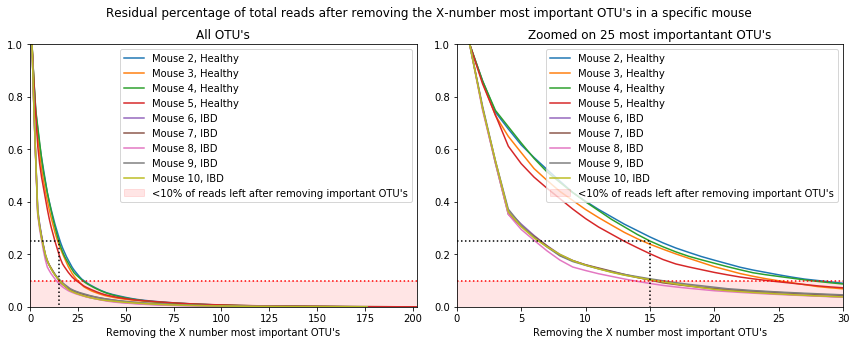

In [ ]:
# Top 10 OTU's for every mouse
f,ax = plt.subplots(1,2, figsize=(12,5))

for mouse in range(2,11):
    quant_perc = data[mouse]['reads_quant_mean'].values
    quant_perc = np.sum(quant_perc, axis=1)
    index = np.argsort(quant_perc)
    title = ', Healthy' if mouse in set(range(2,6)) else ', IBD'
    ax[0].plot(range(len(np.cumsum(quant_perc[index]/quant_perc.sum())),0,-1), np.cumsum(quant_perc[index]/quant_perc.sum()), label="Mouse "+ str(mouse) + title)
    ax[1].plot(range(len(np.cumsum(quant_perc[index]/quant_perc.sum())),0,-1), np.cumsum(quant_perc[index]/quant_perc.sum()), label="Mouse "+ str(mouse) + title)

f.suptitle("Residual percentage of total reads after removing the X-number most important OTU's in a specific mouse")

for i in [0,1]:
    ax[i].axhspan(0, .1, alpha=0.1, color='r', label="<10% of reads left after removing important OTU's" )
    ax[i].set_xlabel("Removing the X number most important OTU's")
    ax[i].legend()
    ax[i].set_ylim((0,1))
    ax[i].plot([0,15,15], [0.25,0.25,0.0], 'k',linestyle=':')
    ax[i].plot([0,202], [0.1,0.1], 'r',linestyle=':')

ax[0].set_xlim((0,202))
ax[1].set_xlim((0,30))
ax[0].set_title("All OTU's")
ax[1].set_title("Zoomed on 25 most importantant OTU's")

f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Conclusion:**
 - In our IBD group after removing the 15 most important OTU's we have less then 10% of all reads left! 
   - **This indicates a lower biodiversity of microbiome in the IBD mice group!**
 - In our normal group have to removing up to 25-30 important OTU's to account for 90% of the reads: 
   - **In our control group the biodiversity is higher and the reads are better spread out over the different OTUs.**


### Focussing on the 5 most important OTU's (OTU_[1,2,3,4,5]) to grasp variation

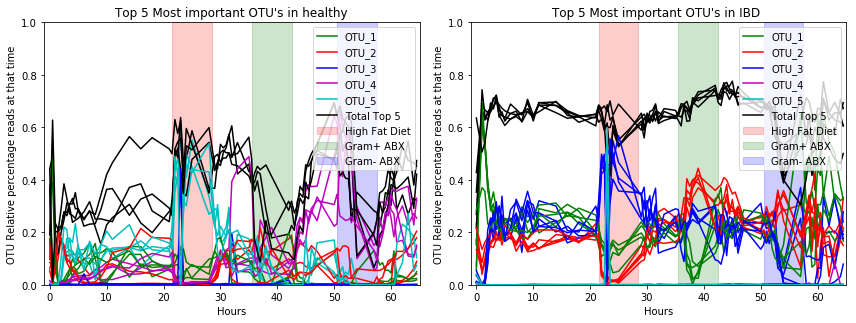

In [ ]:
colors=['g','r','b','m','c']
otus = ['OTU_1', 'OTU_2', 'OTU_3', 'OTU_4', 'OTU_5']


f,ax=plt.subplots(1,2, figsize=(12,5))
for mouse in range(2,11):
    k = 0 if mouse in set(range(2,6)) else 1
    summed=data[mouse]['reads_perc'].loc['OTU_1']*0
    for i,otu in enumerate(otus):
        summed = summed + data[mouse]['reads_perc'].loc[otu]
        ax[k].plot(data[mouse]['times'], data[mouse]['reads_perc'].loc[otu], color=colors[i], label='_'*(not (mouse==6 or mouse==2))+otu )
    ax[k].plot(data[mouse]['times'], summed, color='k', label = '_'*(not (mouse==6 or mouse==2)) + 'Total Top 5')

for i in [0,1]:
    ax[i].axvspan(21.5, 28.5, alpha=0.2, color='r', label='High Fat Diet', )
    ax[i].axvspan(35.5, 42.5, alpha=0.2, color='g', label='Gram+ ABX', )
    ax[i].axvspan(50.5, 57.5, alpha=0.2, color='b', label='Gram- ABX', )
    ax[i].set_xlabel('Hours')
    ax[i].set_ylabel('OTU Relative percentage reads at that time')    
    ax[i].legend(loc="upper right")
    ax[i].set_ylim((0,1))
    ax[i].set_xlim((-1,65))

ax[0].set_title("Top 5 Most important OTU's in healthy")
ax[1].set_title("Top 5 Most important OTU's in IBD ")

f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.show()

**Conclusion:** 
 - a far lower inter-group variation within the IBD mice is observed **this indicates modeling the IBD group will be easier** 
 - related to this we observe that each of the 5 most important OTU's account for a higher percentage of the total reads in our IBD mice 
 - thus also in total we observe that the 5 most important OTU's (black line) accounts for +-50% of the reads at all time except for during the High Fat Diet (red region)
 - during the High fat diet the top-5 most important bugs account for a very low percentage of the total number of reads at that time: 
   - we are having overgrowth of other bacteria prevailing well under high fat diet environments.

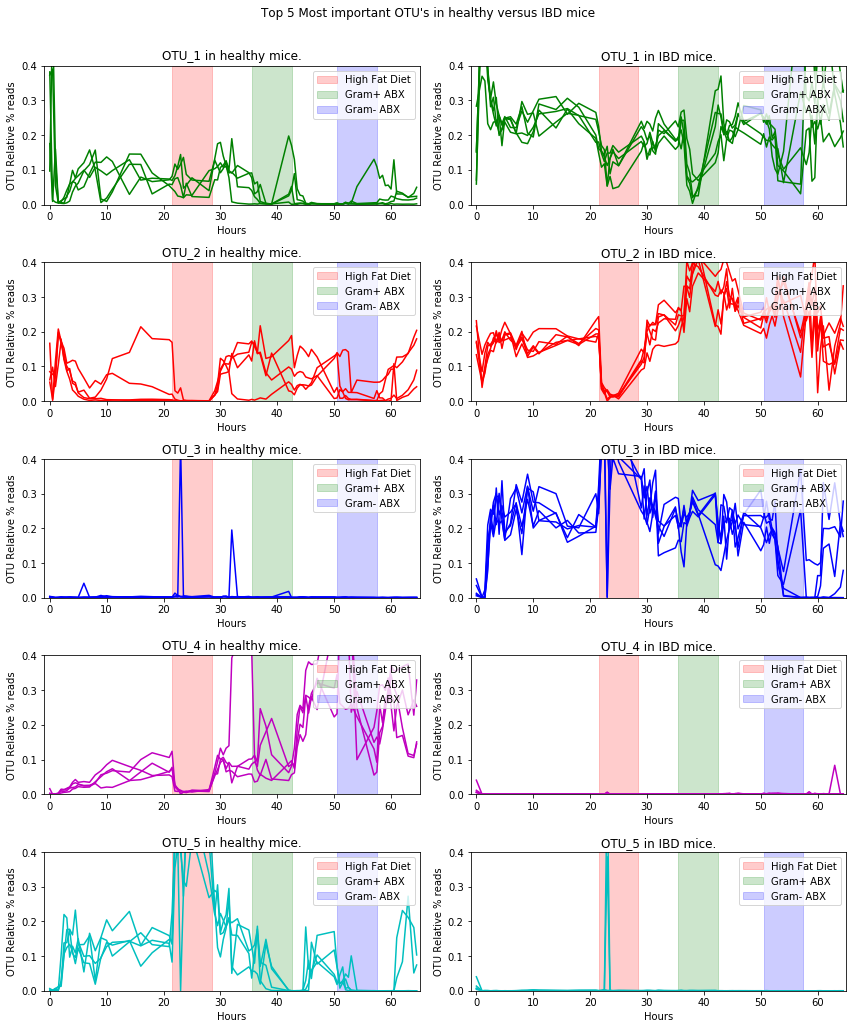

In [ ]:
f,ax = plt.subplots(5,2, figsize=(12,15))
for mouse in range(2,11):
    for i,otu in enumerate(otus):
        k = 0 if mouse in set(range(2,6)) else 1
        title = 'healthy' if mouse in set(range(2,6)) else 'IBD'
        ax[i][k].plot(data[mouse]['times'], data[mouse]['reads_perc'].loc[otu], color=colors[i], label='_')
        ax[i][k].set_title(otu + ' in ' + title + ' mice.')
        ax[i][k].set_ylim((0, 0.4))
        ax[i][k].set_xlim((-1,65))
        if mouse == 2 or mouse ==6:
            ax[i][k].axvspan(21.5, 28.5, alpha=0.2, color='r', label='_'*(not (mouse==6 or mouse==2)) + 'High Fat Diet', )
            ax[i][k].axvspan(35.5, 42.5, alpha=0.2, color='g', label='_'*(not (mouse==6 or mouse==2)) + 'Gram+ ABX', )
            ax[i][k].axvspan(50.5, 57.5, alpha=0.2, color='b', label='_'*(not (mouse==6 or mouse==2)) + 'Gram- ABX', )
            ax[i][k].legend(loc="upper right")
            ax[i][k].set_xlabel('Hours')
            ax[i][k].set_ylabel('OTU Relative % reads')    

f.suptitle("Top 5 Most important OTU's in healthy versus IBD mice")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.show()

In [ ]:
print('The 15 most important bugs are:')
important= ['OTU_1',  'OTU_2',  'OTU_3',  'OTU_4',  'OTU_5',  
            'OTU_6',  'OTU_7',  'OTU_8',  'OTU_9',  'OTU_10', 
            'OTU_11', 'OTU_13', 'OTU_15', 'OTU_17', 'OTU_18' ]
print(important)

The 15 most important bugs are:
['OTU_1', 'OTU_2', 'OTU_3', 'OTU_4', 'OTU_5', 'OTU_6', 'OTU_7', 'OTU_8', 'OTU_9', 'OTU_10', 'OTU_11', 'OTU_13', 'OTU_15', 'OTU_17', 'OTU_18']


### In every mouse they account for the following percentage Y of all reads at a certain time X.

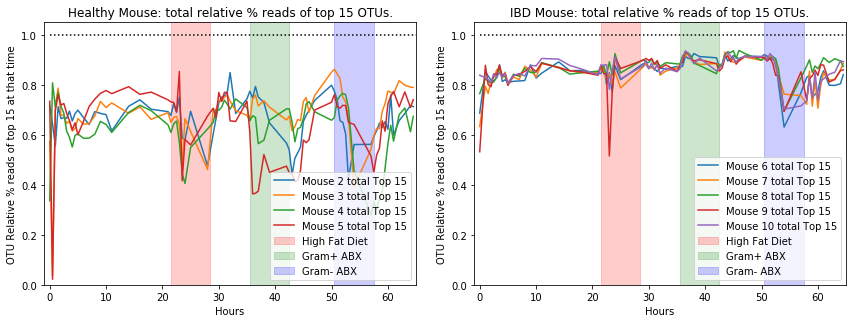

In [ ]:
f,ax = plt.subplots(1,2, figsize=(12,5))
for mouse in range(2,11):
    k = 0 if mouse in set(range(2,6)) else 1
    summed=data[mouse]['reads_perc'].loc['OTU_1']*0
    for i,otu in enumerate(important):
        summed = summed + data[mouse]['reads_perc'].loc[otu]
    ax[k].plot(data[mouse]['times'], summed, label = 'Mouse ' + str(mouse) + ' total Top 15')
    
for i in [0,1]:
    ax[i].axvspan(21.5, 28.5, alpha=0.2, color='r', label='High Fat Diet', )
    ax[i].axvspan(35.5, 42.5, alpha=0.2, color='g', label='Gram+ ABX', )
    ax[i].axvspan(50.5, 57.5, alpha=0.2, color='b', label='Gram- ABX', )
    ax[i].set_xlabel('Hours')
    ax[i].set_ylabel('OTU Relative % reads of top 15 at that time') 
    ax[i].legend(loc="lower right")
    ax[i].set_ylim((0,1.05))
    ax[i].plot([0,73], [1,1], 'k',linestyle=':')
    ax[i].set_xlim((-1,65))

ax[0].set_title('Healthy Mouse: total relative % reads of top 15 OTUs.')
ax[1].set_title('IBD Mouse: total relative % reads of top 15 OTUs.')

f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.show()

**Conclusion:**
 - Again very clear observation that 15 OTUs account for the vast majority of the reads in our IBD mice at all time, and **even during perturbation the IBD group shows way lower biodiversity!**
 - During the perturbations (High Fat diet and Antibiotics) the top 15 OTUs account for less of the total reads at that moment.
 - This is normal since we selected on sorting the OTU's over all time, and during the majority of time we are not experiencing a perturbations.
 - It might make sense to add some important OTUs that specifically grow during these perturbations -> next step.

### Which OTUs are most prevalent during perturbations?

In [ ]:
# Get the specific indices of when we observe perturbations
# Watch out: this indices is out of phase by 1 index between healthy and IBD
# The are not the same length
perturbation = list(np.arange(21.5, 29.0,0.5))+list(np.arange(35.5, 43.0,0.5))+list(np.arange(50.5, 58.0,0.5))
perturbation_times_healthy = { ind:time for ind,time in enumerate(data[2]['times']) if time in set(perturbation) }
perturbation_times_IBD = { ind:time for ind,time in enumerate(data[9]['times']) if time in set(perturbation) }

In [ ]:
List_indices_perturbations_healthy = np.array(list(perturbation_times_healthy.keys()))
List_indices_perturbations_IBD = np.array(list(perturbation_times_IBD.keys()))

In [ ]:
# Top 10 OTU's for every mouse during perturbations!
best_10={}
for mouse in range(2,6):
    quant_perc = data[mouse]['reads_quant_mean'].iloc[List_indices_perturbations_healthy].values
    quant_perc = np.sum(quant_perc, axis=1)
    index = np.argsort(quant_perc)
    best_10[mouse] = [int(s[4:]) for s in data[mouse]['reads_quant_mean'].index[index[-1:-14:-1]].values]
    print("The Top 10 Most prevelant OTU's for mouse ", mouse, " are :\n", best_10[mouse])
for mouse in range(6,11):
    quant_perc = data[mouse]['reads_quant_mean'].iloc[List_indices_perturbations_IBD].values
    quant_perc = np.sum(quant_perc, axis=1)
    index = np.argsort(quant_perc)
    best_10[mouse] = [int(s[4:]) for s in data[mouse]['reads_quant_mean'].index[index[-1:-14:-1]].values]
    print("The Top 10 Most prevelant OTU's for mouse ", mouse, " are :\n", best_10[mouse])

The Top 10 Most prevelant OTU's for mouse  2  are :
 [5, 3, 8, 7, 4, 11, 12, 9, 15, 13, 10, 16, 1]
The Top 10 Most prevelant OTU's for mouse  3  are :
 [3, 7, 5, 8, 11, 4, 12, 9, 10, 13, 15, 25, 18]
The Top 10 Most prevelant OTU's for mouse  4  are :
 [3, 5, 8, 7, 4, 16, 9, 15, 11, 12, 1, 10, 21]
The Top 10 Most prevelant OTU's for mouse  5  are :
 [3, 7, 5, 8, 4, 9, 12, 10, 11, 25, 15, 14, 20]
The Top 10 Most prevelant OTU's for mouse  6  are :
 [2, 1, 5, 3, 6, 7, 15, 10, 16, 8, 11, 21, 12]
The Top 10 Most prevelant OTU's for mouse  7  are :
 [5, 2, 1, 3, 6, 7, 15, 10, 16, 8, 11, 19, 21]
The Top 10 Most prevelant OTU's for mouse  8  are :
 [1, 2, 6, 5, 7, 3, 10, 16, 19, 15, 8, 21, 23]
The Top 10 Most prevelant OTU's for mouse  9  are :
 [1, 2, 5, 3, 6, 7, 10, 16, 11, 8, 19, 14, 4]
The Top 10 Most prevelant OTU's for mouse  10  are :
 [2, 5, 6, 1, 3, 7, 11, 10, 16, 18, 24, 15, 23]


In [ ]:
concat = np.concatenate(list(best_10.values()))
otu, counts = np.unique(concat, return_counts=True)
for otu_x , count in (zip(otu, counts)):
    print('OTU', otu_x ,'\tappears ', count , "\ttimes in the top 10's of all mice")

OTU 1 	appears  5 	times in the top 10's of all mice
OTU 2 	appears  5 	times in the top 10's of all mice
OTU 3 	appears  9 	times in the top 10's of all mice
OTU 4 	appears  4 	times in the top 10's of all mice
OTU 5 	appears  9 	times in the top 10's of all mice
OTU 6 	appears  5 	times in the top 10's of all mice
OTU 7 	appears  9 	times in the top 10's of all mice
OTU 8 	appears  7 	times in the top 10's of all mice
OTU 9 	appears  4 	times in the top 10's of all mice
OTU 10 	appears  7 	times in the top 10's of all mice
OTU 11 	appears  6 	times in the top 10's of all mice
OTU 12 	appears  4 	times in the top 10's of all mice
OTU 13 	appears  2 	times in the top 10's of all mice
OTU 15 	appears  5 	times in the top 10's of all mice
OTU 16 	appears  6 	times in the top 10's of all mice
OTU 18 	appears  1 	times in the top 10's of all mice
OTU 19 	appears  1 	times in the top 10's of all mice
OTU 25 	appears  1 	times in the top 10's of all mice


**Observation:** OTU 12, 14, 16, 19, 21, 23, 25 all appear more then twice although they were not in the top 10 most important over the global time.
 - Yet **OTU 16** is appearing 7 times in the top 13 during perturbations, although it did not appear ONES in the global top-10s.
 - Also **OTU 12, 14, 19, 21, 23 and 25** appear 4, 2, 3, 4, 2,2 times in the top 13 during perturbations compared to almost never during the global top-10s.
 - **Are OTU 12, 19 and 23 overgrowing during perturbations?**

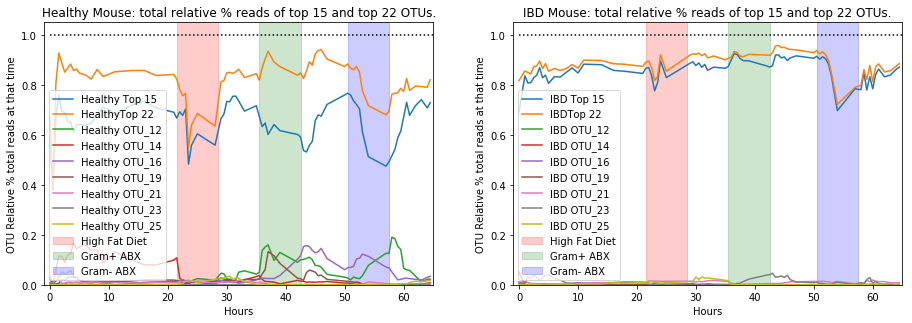

In [ ]:
important15= ['OTU_1',  'OTU_2',  'OTU_3',  'OTU_4',  'OTU_5',  
            'OTU_6',  'OTU_7',  'OTU_8',  'OTU_9',  'OTU_10', 
            'OTU_11', 'OTU_13', 'OTU_15', 'OTU_17', 'OTU_18' ]

important19= ['OTU_1',  'OTU_2',  'OTU_3',  'OTU_4',  'OTU_5',  
            'OTU_6',  'OTU_7',  'OTU_8',  'OTU_9',  'OTU_10', 
            'OTU_11', 'OTU_13', 'OTU_15', 'OTU_17', 'OTU_18', 
            'OTU_12', 'OTU_14', 'OTU_16', 'OTU_19', 'OTU_21',
            'OTU_23', 'OTU_25' ]

f,ax = plt.subplots(1,2, figsize=(13,5))
for i in [0,1]:
    mouse_init=2 if i == 0 else 10
    summed_15=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_22=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU12=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU14=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU16=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU19=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU21=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU23=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU25=data[mouse_init]['reads_perc'].loc['OTU_1']*0
  
    ranger = range(2,6) if i == 0 else range(6,11)
    for mouse in ranger:
        k = 0 if mouse in set(range(2,6)) else 1
        title = 'Healthy' if mouse in set(range(2,6)) else 'IBD'
        for i,otu in enumerate(important15):
            summed_15 = summed_15 + data[mouse]['reads_perc'].loc[otu]
        for i,otu in enumerate(important19):
            summed_22 = summed_22 + data[mouse]['reads_perc'].loc[otu]
        summed_OTU12 = summed_OTU12 + data[mouse]['reads_perc'].loc['OTU_12']
        summed_OTU14 = summed_OTU14 + data[mouse]['reads_perc'].loc['OTU_14']
        summed_OTU16 = summed_OTU16 + data[mouse]['reads_perc'].loc['OTU_16']
        summed_OTU19 = summed_OTU19 + data[mouse]['reads_perc'].loc['OTU_19']
        summed_OTU21 = summed_OTU21 + data[mouse]['reads_perc'].loc['OTU_21']
        summed_OTU23 = summed_OTU23 + data[mouse]['reads_perc'].loc['OTU_23']
        summed_OTU25 = summed_OTU25 + data[mouse]['reads_perc'].loc['OTU_25']

    total = 4 if mouse in set(range(2,6)) else 5
    ax[k].plot(data[mouse]['times'], summed_15/total, label = title + ' Top 15')
    ax[k].plot(data[mouse]['times'], summed_22/total, label = title + 'Top 22')
    ax[k].plot(data[mouse]['times'], summed_OTU12/total, label = title + ' OTU_12')
    ax[k].plot(data[mouse]['times'], summed_OTU14/total, label = title + ' OTU_14')
    ax[k].plot(data[mouse]['times'], summed_OTU16/total, label = title + ' OTU_16')
    ax[k].plot(data[mouse]['times'], summed_OTU19/total, label = title + ' OTU_19')
    ax[k].plot(data[mouse]['times'], summed_OTU21/total, label = title + ' OTU_21')
    ax[k].plot(data[mouse]['times'], summed_OTU23/total, label = title + ' OTU_23')
    ax[k].plot(data[mouse]['times'], summed_OTU25/total, label = title + ' OTU_25')

for i in [0,1]:
    ax[i].axvspan(21.5, 28.5, alpha=0.2, color='r', label='High Fat Diet', )
    ax[i].axvspan(35.5, 42.5, alpha=0.2, color='g', label='Gram+ ABX', )
    ax[i].axvspan(50.5, 57.5, alpha=0.2, color='b', label='Gram- ABX', )
    ax[i].set_xlabel('Hours')
    ax[i].set_ylabel('OTU Relative % total reads at that time')    
    ax[i].legend(loc="lower left")
    ax[i].set_ylim((0,1.05))
    ax[i].plot([0,73], [1,1], 'k',linestyle=':')
    ax[i].set_xlim((-1,65))

ax[0].set_title('Healthy Mouse: total relative % reads of top 15 and top 22 OTUs.')
ax[1].set_title('IBD Mouse: total relative % reads of top 15 and top 22 OTUs.')

f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.show()

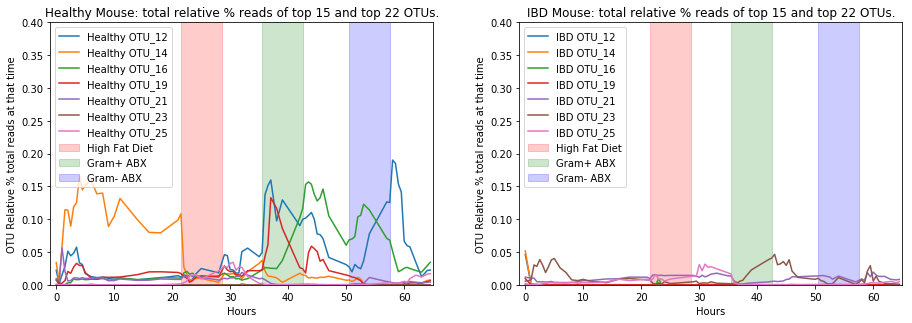

In [ ]:
f,ax = plt.subplots(1,2, figsize=(13,5))
for i in [0,1]:
    mouse_init=2 if i == 0 else 10
    summed_15=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_19=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU12=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU14=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU16=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU19=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU21=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU23=data[mouse_init]['reads_perc'].loc['OTU_1']*0
    summed_OTU25=data[mouse_init]['reads_perc'].loc['OTU_1']*0
  
    ranger = range(2,6) if i == 0 else range(6,11)
    for mouse in ranger:
        k = 0 if mouse in set(range(2,6)) else 1
        title = 'Healthy' if mouse in set(range(2,6)) else 'IBD'
        summed_OTU12 = summed_OTU12 + data[mouse]['reads_perc'].loc['OTU_12']
        summed_OTU14 = summed_OTU14 + data[mouse]['reads_perc'].loc['OTU_14']
        summed_OTU16 = summed_OTU16 + data[mouse]['reads_perc'].loc['OTU_16']
        summed_OTU19 = summed_OTU19 + data[mouse]['reads_perc'].loc['OTU_19']
        summed_OTU21 = summed_OTU21 + data[mouse]['reads_perc'].loc['OTU_21']
        summed_OTU23 = summed_OTU23 + data[mouse]['reads_perc'].loc['OTU_23']
        summed_OTU25 = summed_OTU25 + data[mouse]['reads_perc'].loc['OTU_25']

    total = 4 if mouse in set(range(2,6)) else 5
    ax[k].plot(data[mouse]['times'], summed_OTU12/total, label = title + ' OTU_12')
    ax[k].plot(data[mouse]['times'], summed_OTU14/total, label = title + ' OTU_14')
    ax[k].plot(data[mouse]['times'], summed_OTU16/total, label = title + ' OTU_16')
    ax[k].plot(data[mouse]['times'], summed_OTU19/total, label = title + ' OTU_19')
    ax[k].plot(data[mouse]['times'], summed_OTU21/total, label = title + ' OTU_21')
    ax[k].plot(data[mouse]['times'], summed_OTU23/total, label = title + ' OTU_23')
    ax[k].plot(data[mouse]['times'], summed_OTU25/total, label = title + ' OTU_25')

for i in [0,1]:
    ax[i].axvspan(21.5, 28.5, alpha=0.2, color='r', label='High Fat Diet', )
    ax[i].axvspan(35.5, 42.5, alpha=0.2, color='g', label='Gram+ ABX', )
    ax[i].axvspan(50.5, 57.5, alpha=0.2, color='b', label='Gram- ABX', )
    ax[i].set_xlabel('Hours')
    ax[i].set_ylabel('OTU Relative % total reads at that time')    
    ax[i].legend(loc="upper left")
    ax[i].set_ylim((0,.4))
    ax[i].set_xlim((-1,65))

ax[0].set_title('Healthy Mouse: total relative % reads of top 15 and top 22 OTUs.')
ax[1].set_title('IBD Mouse: total relative % reads of top 15 and top 22 OTUs.')

f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.show()

**Conclusion:** 
 - Adding these 7 OTU's to the 15 most important ones did improve the low coverage of reads during the perturbations; especially during antibioticcs in the healthy mice.
 - Specifically OTU_12(blue), OTU_16(green), and OTU_19(red) seems to grow well during antibiotic treatment yet only in healthy mouse: this might be clinically relevant.
  - In IBD we already cover most reads just with the top 15 and only OTU_23 seems to overgrow a little bit during antibiotic treatment.

### Final conclusion: It seems reasonable to further explore the interactions among the important OTU'S covering 85-90% of all reads to model our system. In This work, we will focus on the first 20 most important OTU.

We show here the taxonomy of several most important OTUs

In [ ]:
display(data[2]['otu_taxonomy'].iloc[:25,2:])

Phylum                Class               Order  \
otuName                                                             
OTU_1      Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_2      Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_3    Verrucomicrobia     Verrucomicrobiae  Verrucomicrobiales   
OTU_4      Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_5    Verrucomicrobia     Verrucomicrobiae  Verrucomicrobiales   
OTU_6     Proteobacteria   Betaproteobacteria     Burkholderiales   
OTU_7      Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_8      Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_9      Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_10     Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_11     Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_12     Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_13     Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_14     Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_15    Proteobacteria  Gammaproteobacteria   Enterobacteriales   
OTU_16     Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_17        Firmicutes        Negativicutes     Selenomonadales   
OTU_18        Firmicutes           Clostridia       Clostridiales   
OTU_19     Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_20        Firmicutes           Clostridia       Clostridiales   
OTU_21     Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_22     Bacteroidetes          Bacteroidia       Bacteroidales   
OTU_23    Proteobacteria   Betaproteobacteria     Burkholderiales   
OTU_24    Proteobacteria  Deltaproteobacteria  Desulfovibrionales   
OTU_25        Firmicutes           Clostridia       Clostridiales   

                      Family                  Genus  
otuName                                              
OTU_1         Bacteroidaceae            Bacteroides  
OTU_2         Bacteroidaceae            Bacteroides  
OTU_3    Verrucomicrobiaceae            Akkermansia  
OTU_4         Bacteroidaceae            Bacteroides  
OTU_5    Verrucomicrobiaceae            Akkermansia  
OTU_6         Sutterellaceae         Parasutterella  
OTU_7         Bacteroidaceae            Bacteroides  
OTU_8         Bacteroidaceae            Bacteroides  
OTU_9         Bacteroidaceae            Bacteroides  
OTU_10        Bacteroidaceae            Bacteroides  
OTU_11        Bacteroidaceae            Bacteroides  
OTU_12        Bacteroidaceae            Bacteroides  
OTU_13    Porphyromonadaceae        Parabacteroides  
OTU_14        Bacteroidaceae            Bacteroides  
OTU_15    Enterobacteriaceae   Escherichia/Shigella  
OTU_16    Porphyromonadaceae        Parabacteroides  
OTU_17    Acidaminococcaceae  Phascolarctobacterium  
OTU_18       Lachnospiraceae       Clostridium_XlVa  
OTU_19        Bacteroidaceae            Bacteroides  
OTU_20       Lachnospiraceae                Blautia  
OTU_21    Porphyromonadaceae        Parabacteroides  
OTU_22    Porphyromonadaceae        Parabacteroides  
OTU_23        Sutterellaceae             Sutterella  
OTU_24   Desulfovibrionaceae              Bilophila  
OTU_25       Lachnospiraceae       Clostridium_XlVa

## Granger Causality Analysis <a name="granger"></a>

Inspired by the work of [Tank et al.](https://arxiv.org/pdf/1802.05842.pdf), we investigate the notion of Granger Causality in the time-series of the various microbes. The idea is to see if we can determine some sort of "temporal interaction links" between the microbes. Specifically, in Granger ‘causality’ analysis, we test whether the addition of a prediction of the time-series from another time-series may improve our prediction of the present behavior of the time-series (i.e. reducing the prediction error). 

Given that the time-series from the dataset appear to be highly non-linear, we employ Long Short-Term Memory (LSTM) recurrent neural networks as a robust non-linear time-dependent model. The way the paper implements the Granger causality is by creating one LSTM per time-series, and allowing the hidden outputs from each time-series to be potentially used by the others for making predictions. They penalize these weights being non-zero, so the network makes a tradeoff between using the information in the other series and lowering the loss. Then the Granger "causality" of a series $i$ on series $j$ is just the norm of the first-layer hidden weights of $i$ going to $j$.

The authors of the paper provide a convenient PyTorch implementation of their model, which we use below: https://github.com/icc2115/Neural-GC. 

### Bayesian Hyperparameter Optimization <a name="bayes_opt"></a>

Due to the sensitivity of the cLSTM's hyperparameters, we use Bayesian optimization to discover a high-performing set of training and regularization hyperparameter values. Bayesian optimization is a natural framework for hyperparameter search. It excels at optimization under uncertainty, particularly with noisy black-box functions that are expensive to evaluate, such as training and evaluating neural networks.

Under the Bayesian optimization framework, we wish to identify a set of hyperparameters $\theta^\ast$ such that,

$$
\theta^\ast \approx \arg\max_\theta \sigma(f(\mathcal{D};\theta))
$$

where $f$ is the model whose hyperparameters we wish to tune and $\sigma(\cdot)$ is a scoring model on $f$. In other words, we wish to find the hyperparameters $\theta$ of a model that maximizes its score (defined below).

First, we'll load in the data and prepare it for training. We are interested in modeling the 20 most prevalent OTUs present in all 9 mice.

In [13]:
import torch
import numpy as np
from scipy.stats import beta
from utils import load_data

from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events

from clstm import cLSTM, train_model_gista, train_model_adam

In [9]:
mice = load_data()

In [10]:
mouse2 = mice[2]

In [11]:
# percent reads / times
mouse2_pct = mouse2['reads_percent']
mouse2_abs = mouse2['reads_abs_mean']

In [12]:
IMP_READS = np.arange(20)
top_reads_pct = mouse2_pct[IMP_READS, :].T
top_reads_abs = mouse2_abs[IMP_READS, :].T

mean_abs = np.mean(top_reads_abs, axis=0)
std_abs = np.std(top_reads_abs, axis=0)
top_reads_abs = (top_reads_abs - mean_abs) / std_abs

X_torch_pct = torch.tensor(top_reads_pct[np.newaxis], dtype=torch.float32)
X_torch_abs = torch.tensor(top_reads_abs[np.newaxis], dtype=torch.float32)

Now, let's define the score model $\sigma$. The score function is tricky in this context because we do not actually have a concrete way of quantifying how well a model is doing. Since we're interested in the Granger Causality coefficients and not the overall predictive power, just using the MSE loss would not give us the results we want. However, we can encode the belief that we expect there to be some causal links between bacteria. We also believe that causal links should generally be more prevalant along the diagonal. This led us to develop the following score function:

$$
\sigma(C) = \text{Beta}(\mathbb{E}[C]; \alpha, \beta) + \mathbb{E}[\text{diag}\{C\}] \cdot \left(1 - \prod_i \mathbb{1}_{c_i = 1}\right)
$$

where we use $\alpha = \beta = 1.6$, and $C \in \{0, 1\}^{NxN}$ is the collection of Granger Causality terms. In other words, we reward models with a mixture of zero and non-zero GC terms, and we further reward models with diagonal GC terms.

This function is imprecise, but allows us to run optimization in order to find models that provide interesting results. In practice, non-lienar models are extremely difficult to train and most get all non-zero or all zero GC values. Thus, any model that gets a non-zero score with the above function is potentially of value to us. Whether or not it is precisely calibrated, it is useful in helping us discover hyperparameter confugirations that are useful to us.

In [14]:
def get_gc_score(gc):
    score = beta(a=1.6, b=1.6).pdf(gc.mean())
    score += gc.diagonal().mean() * (gc.mean() != 1.)
    return score

In [22]:
heatmaps = []
def evaluate(n_hidden, lr_scale, lam_scale, lam_ridge_scale, truncation, data=X_torch_abs, max_iter=2500):
    """ 
    Evaluate a given set of hyperparameters, training a model for 2500 epochs
    and returning a score.
    
    This is the black-box function which our Bayesian Optimization algorithm
    will attempt to optimize
    """
    # transform continues values into valid hyperparams
    n_hidden = int(n_hidden + .5)
    truncation = int(truncation + .5)
    lr = 10**lr_scale
    lam = 10**lam_scale
    lam_ridge = 10**lam_ridge_scale
    
    # train the model
    gcmodel = cLSTM(p, n_hidden)
    gcmodel.to('cuda')
    train_loss_list, train_mse_list = train_model_gista(
        gcmodel,
        data.to('cuda'),
        lam=lam,
        lam_ridge=lam_ridge,
        lr=lr,
        max_iter=max_iter,
        check_every=100,
        truncation=truncation,
        verbose=1
    )
    gc = gcmodel.GC(threshold=False).cpu().detach().numpy()
    heatmaps.append(gc)
    eval_heatmaps.append(gc)
    gc_thresh = (heatmaps[-1] > 0).astype('float')
    
    # return the resulting model's score
    return get_gc_score(gc_thresh)

Here, we define the range of hyperparameters which the algorithm should search over. We optimize the following ranges:

- **\# of hidden LSTM nodes:** min: 10, max: 256
- **Learning rate:** min: .00001, max: .01 (searched on log 10 scale)
- **GC sparsity penalty:**, min: .000001, max: 1 (searched on log 10 scale)
- **LSTM Ridge term:** min: .000001, max: 1 (searched on log 10 scale)
- **Time series window:** min: 3, max: 20

In [16]:
pbounds = {
    'n_hidden': (10, 256),
    'lr_scale': (-2, -5),
    'lam_scale': (0, -6),
    'lam_ridge_scale': (0, -6),
    'truncation': (3, 20)
}

In [17]:
optimizer = BayesianOptimization(
    f=evaluate,
    pbounds=pbounds,
    verbose=0
)

We then optimize using the Expected Improvement acquisition function, which essentially chooses new hyperparameters based on which point in hyperparameter space has the highest expected improvement over the maximum score we have seen so far.

Since each point is extremely expensive to evaluate, we plot 5 initial random values and then 12 points selected according to our acquistion, saving the results in a `.json` file.

In [240]:
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTMIZATION_STEP, logger)

In [ ]:
optimizer.maximize(
    init_points=5,
    n_iter=12,
    acq='ei'
)

In [21]:
optimizer.max

{'target': 1.9629146090709826,
 'params': {'lam_ridge_scale': -5.420411491727301,
  'lam_scale': -0.8248482248774252,
  'lr_scale': -2.4178290417522756,
  'n_hidden': 208.61825702254285,
  'truncation': 8.555859902725139}}

The best model we found had a score of `1.96` (which is largely uninterpretable). It seemed to learn very small LSTM regression terms ($10^{-5.42}=0.0000038$) and relatively large terms for the GC sparsity regularization ($10^{-.82}=0.15$), as well as a window size of $9$ and $209$ hidden LSTM units, trained with a learning rate of $10^{-2.41}= 0.003$. In our experiments, we found this hyperparameter configuration did indeed give us well-performing models whose GC values were relatively consistent across experiments.

### Cross-mice Granger Casuality <a name="sep_mice"></a>

Now that we've done our hyperparameter search, we will can perform the experiment with a well-performing model for the same 20 bugs across each of the 9 mice. We'll store the GC values in the `heatmaps` array so that we can compare their interactions across experiments.

In [ ]:
for i, mouse in mice.items():
    print(f'Mouse {i}')
    # percent reads / times
    mouse2_abs = mouse['reads_abs_mean']
    top_reads_abs = mouse2_abs[IMP_READS, :].T

    mean_abs = np.mean(top_reads_abs, axis=0)
    std_abs = np.std(top_reads_abs, axis=0)
    top_reads_abs = (top_reads_abs - mean_abs) / std_abs

    X_torch_abs = torch.tensor(top_reads_abs[np.newaxis], dtype=torch.float32)
    
    score = evaluate(**optimizer.max['params'], data=X_torch_abs)
    print(score, '\n')

In [ ]:
heatmaps = np.array(heatmaps)

In [259]:
np.save('all_mice_heatmaps', heatmaps)

Now we can see the GC values for each of the mice. Note that mice 2-5 correspond to healthy patients and mice 6-10 correspond to patients with IBD. Notably, the distribution of GC values looks much more similar within these groups.

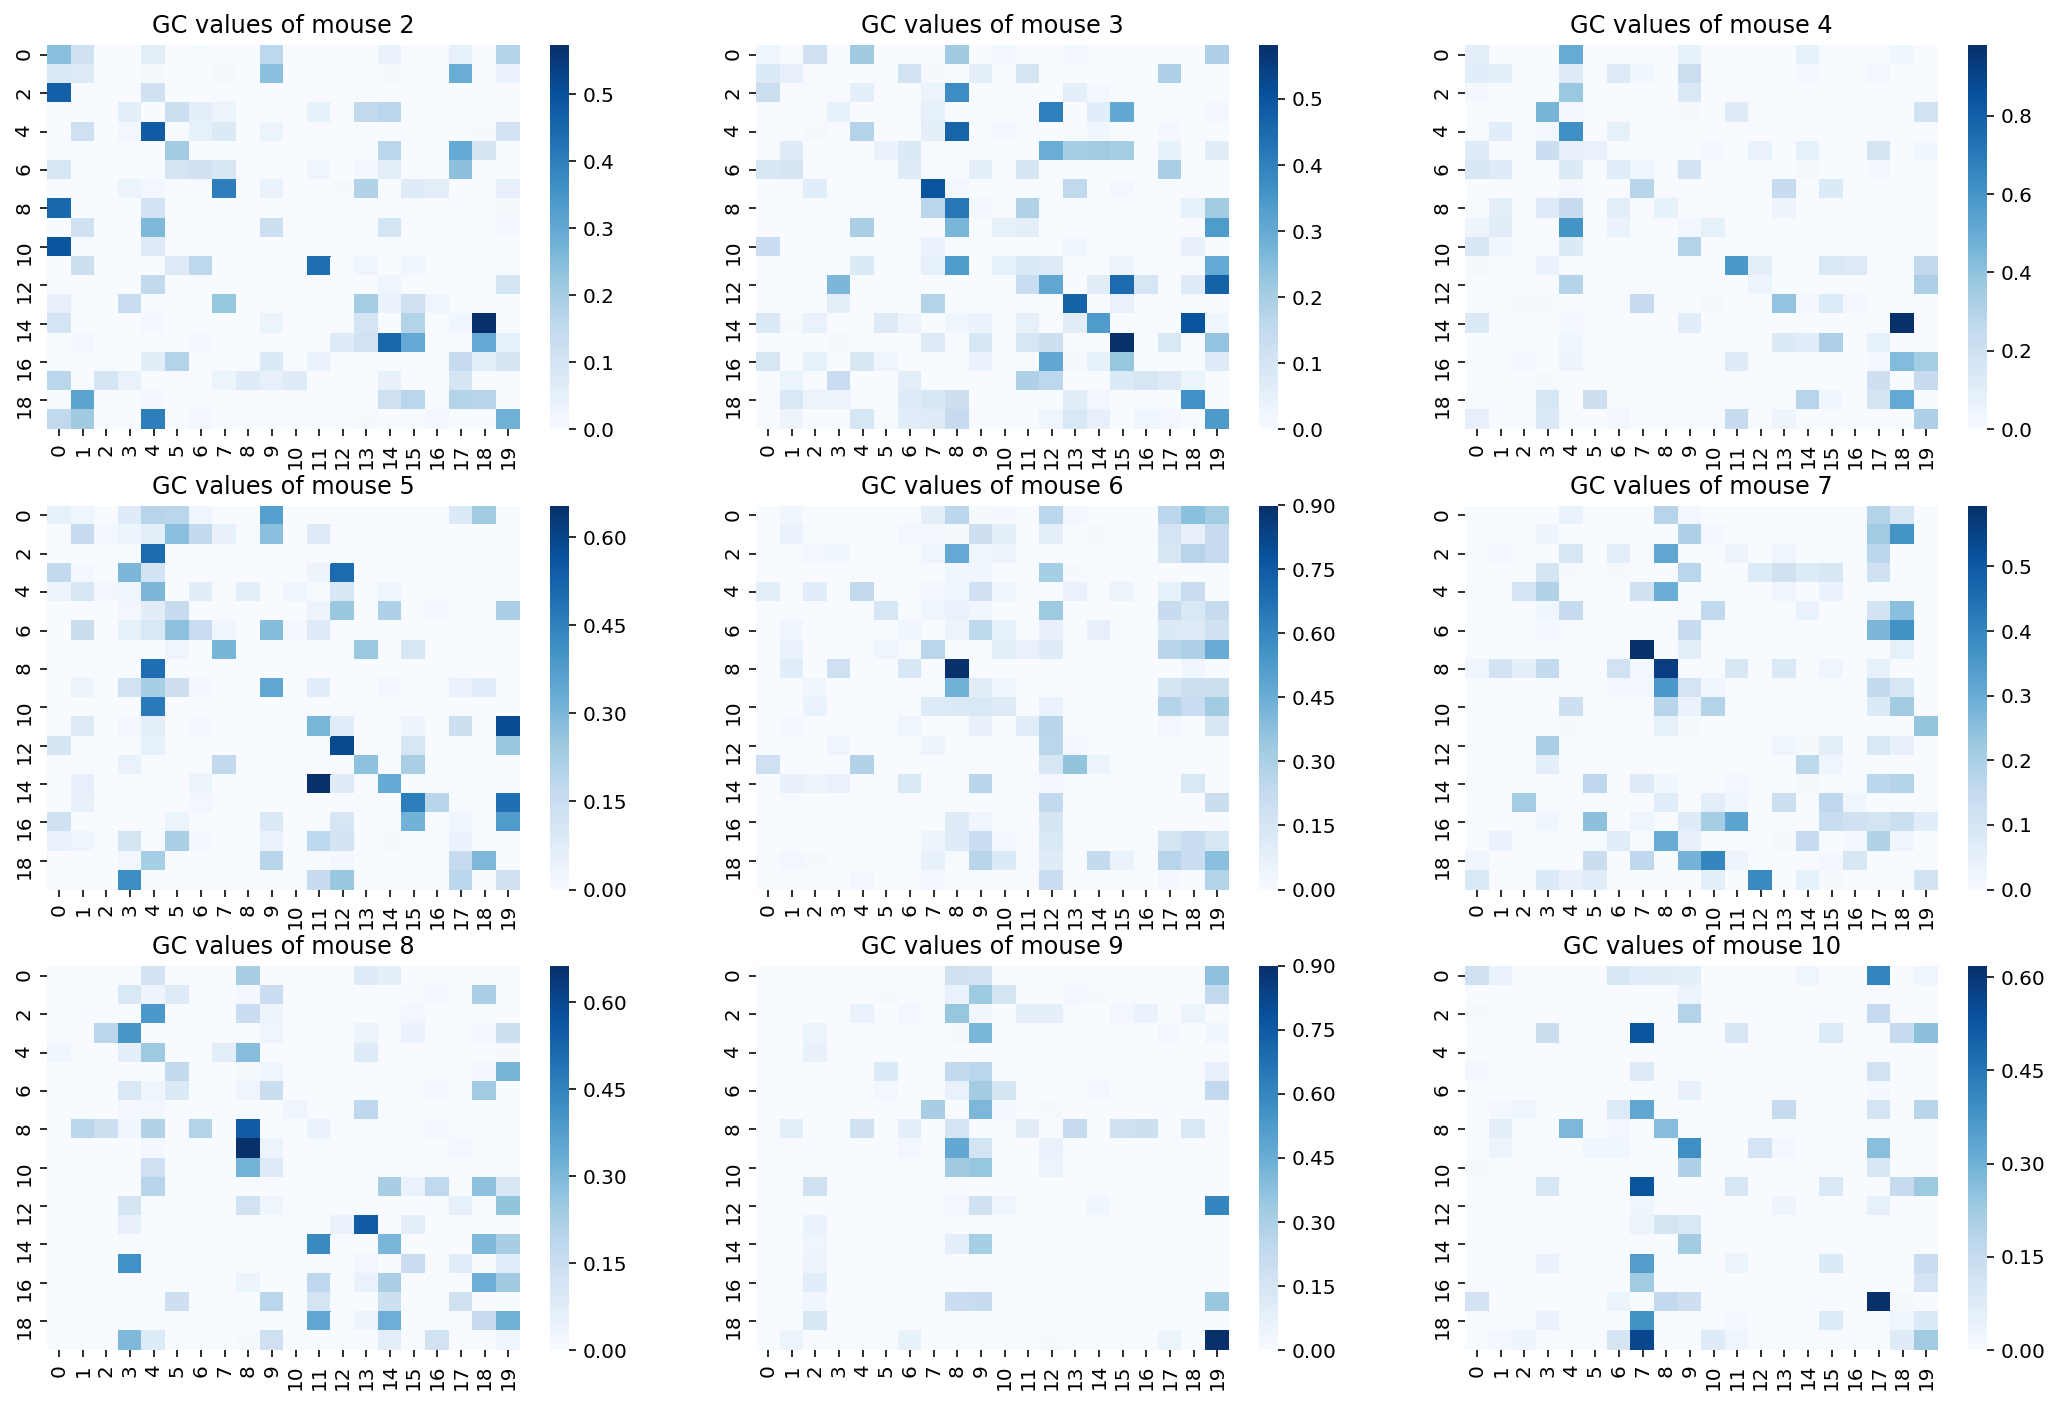

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
for iax, ax in enumerate(axes.ravel()):
    sns.heatmap(heatmaps[iax,-1], ax=ax, cmap='Blues')
    ax.set_title(f'GC values of mouse {iax+2}')

**Note:** The way to interpret these graphs is that *column $j$* has a Granger-causal relationship with *row $i$*. 

We can put this in a graph which is easier to interpret. 
- First, we show the 15 most important interactions on a graph for every mouse individually.
- Second, we show the 15 most important interactions of the average GC values within healthy mice and the average GC values within IBD mice.

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import warnings

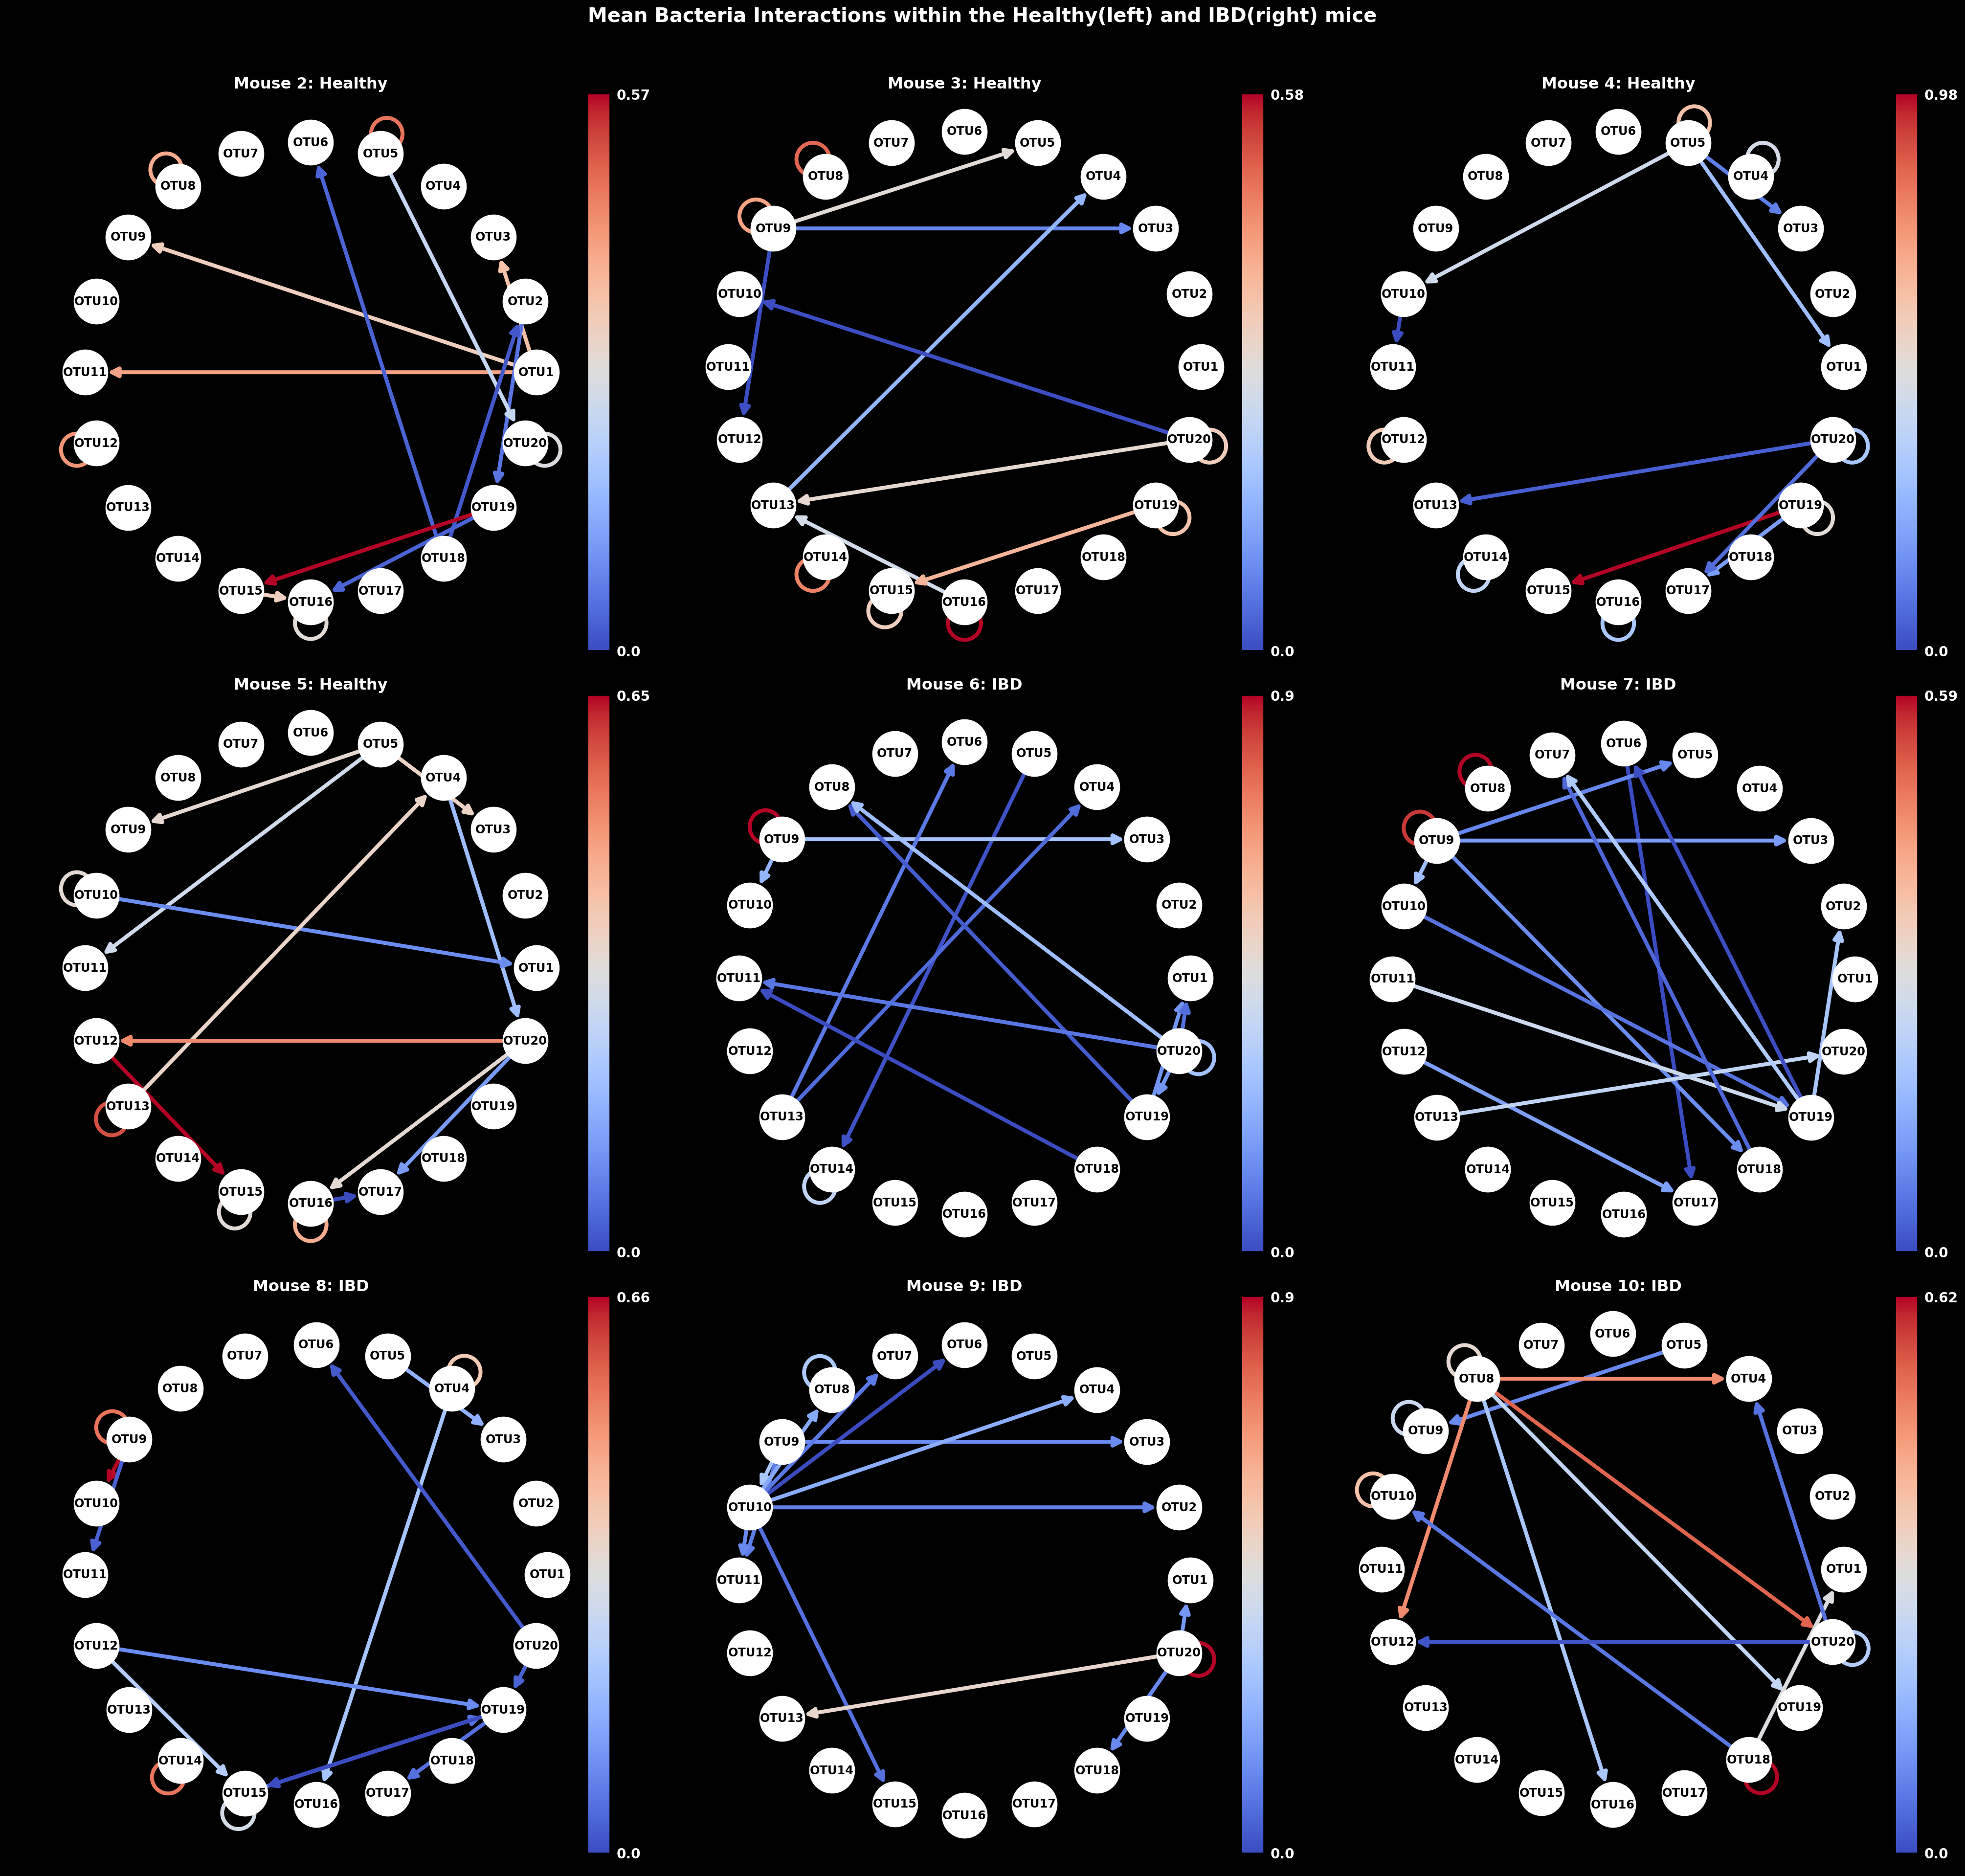

In [3]:
plot_how_many = 15 # Indicate how many interactions you want to plot!

all_heatmaps = np.load('all_mice_heatmaps.npy')
f, ax = plt.subplots(3,3, figsize=(28,28))
ax=ax.flatten()
for k,mouse in enumerate(range(2,11)):
    Heatmap=all_heatmaps[k,-1,:,:]
    G = nx.MultiDiGraph()
    length = len(Heatmap)
    ids = list()
    for i in range(length):
        ids.append('OTU'+str(i+1))
        G.add_node(ids[i], size=100)
    widths=[]
    sort = np.sort(Heatmap.flatten())
    self_loop=[]
    
    for i in range(length):
        for j in range(length):
            if Heatmap[j,i] > sort[-plot_how_many-1] : 
                G.add_edge(ids[i],ids[j])
                widths.append(Heatmap[j,i])
                if i == j: 
                    self_loop.append(Heatmap[j,i])
                    
    widths=np.array(widths)/sort[-1]
    pos = nx.circular_layout(G)
    norm = mpl.colors.Normalize(vmin=0, vmax=sort[-1])
    cmap = mpl.cm.get_cmap('coolwarm')
    
    im = nx.draw_circular(G, with_labels=True, node_size=2100, node_color='w', font_color='k',
                          edge_color=list(widths.flatten()), ax = ax[k], edge_cmap=plt.cm.coolwarm, 
                          vmin=0, vmax=1, alpha=1,
                          width=4, hold=True, arrowsize=20, font_size=12, font_weight='bold',
                          connectionstyle='arc3, rad=0.1')
    for i,idx in enumerate(G.nodes_with_selfloops()): 
        circle = plt.Circle((pos[idx][0]*1.09, pos[idx][1]*1.09), radius=0.07, 
                            edgecolor=cmap(self_loop[i]/sort[-1]), fill=False, linewidth=4)
        ax[k].add_artist(circle)    

    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes('right', size='4%', pad=0.06)
    cb1 = mpl.colorbar.ColorbarBase(ax=cax, cmap = plt.cm.coolwarm, 
                                    norm = norm, ticks=[0*sort[-plot_how_many], sort[-1]])
    cax.set_yticklabels([0*round(sort[-plot_how_many],2), round(sort[-1],2)], 
                           color = 'w', size=14, fontweight='bold')
    title = ': Healthy' if mouse in range(2,6) else ': IBD'
    ax[k].set_title('Mouse ' + str(mouse) + title ,color ='w', size=16, fontweight='bold')

f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.set_facecolor('k')
f.suptitle('Mean Bacteria Interactions within the Healthy(left) and IBD(right) mice', color = 'w', size=20, fontweight='bold')
plt.show()

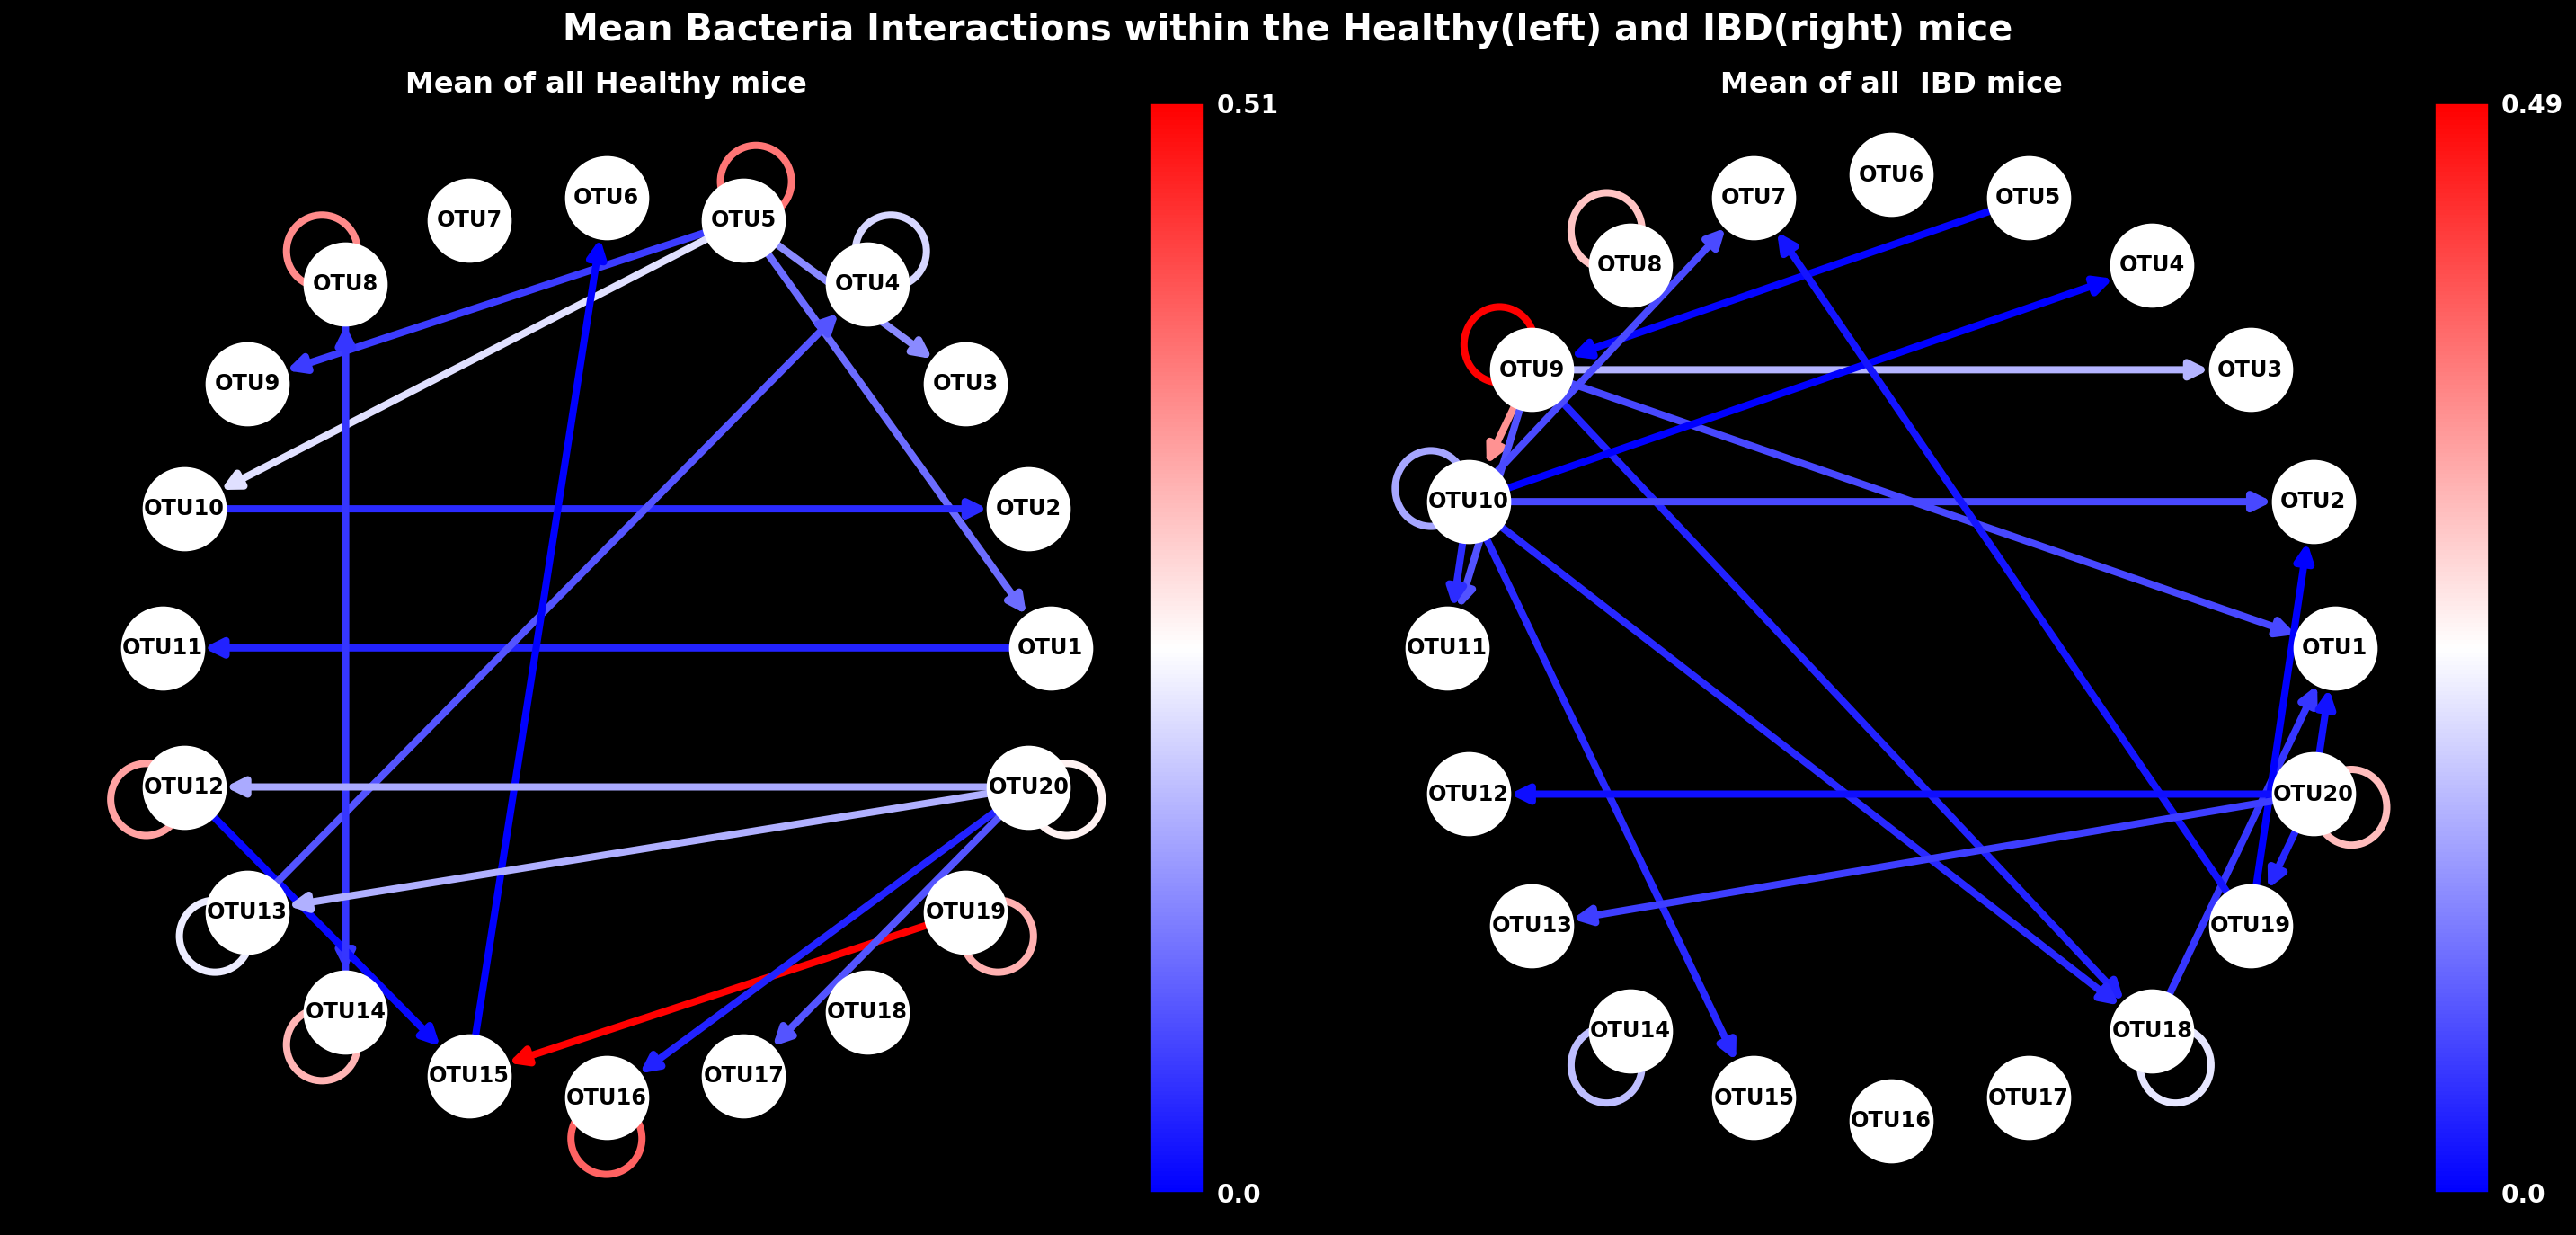

In [4]:
Heatmap_mean={}
Heatmap_mean[0]=np.mean(all_heatmaps[0:4,-1,:,:] ,axis=0) 
Heatmap_mean[1]=np.mean(all_heatmaps[4:,-1,:,:] ,axis=0) 
f, ax = plt.subplots(1,2, figsize=(20,10))
plot_how_many = 25
ax=ax.flatten()

Heatmap=all_heatmaps[k,-1,:,:]
for k in range(0,2):
    Heatmap=Heatmap_mean[k]
    G = nx.MultiDiGraph()
    length = len(Heatmap)
    ids = list()
    for i in range(length):
        ids.append('OTU'+str(i+1))
        G.add_node(ids[i], size=100)
    widths=[]
    sort = np.sort(Heatmap.flatten())
    self_loop=[]
    
    for i in range(length):
        for j in range(length):
            if Heatmap[j,i] > sort[-plot_how_many-1] : 
                G.add_edge(ids[i],ids[j])
                widths.append(Heatmap[j,i])
                if i == j: 
                    self_loop.append(Heatmap[j,i])
                    
    widths=np.array(widths)/sort[-1]
    pos = nx.circular_layout(G)
    norm = mpl.colors.Normalize(vmin=0, vmax=sort[-1])
    cmap = mpl.cm.get_cmap('bwr')
    
    im = nx.draw_circular(G, with_labels=True, node_size=2100, node_color='w', font_color='k',
                          edge_color=list(widths.flatten()), ax = ax[k], edge_cmap=plt.cm.bwr, 
                          vmin=0, vmax=1, alpha=1,
                          width=4, hold=True, arrowsize=20, font_size=12, font_weight='bold',
                          connectionstyle='arc3, rad=0.1')
    for i,idx in enumerate(G.nodes_with_selfloops()): 
        circle = plt.Circle((pos[idx][0]*1.09, pos[idx][1]*1.09), radius=0.08, 
                            edgecolor=cmap(self_loop[i]/sort[-1]), fill=False, linewidth=4)
        ax[k].add_artist(circle)    

    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb1 = mpl.colorbar.ColorbarBase(ax=cax, cmap = plt.cm.bwr, 
                                    norm = norm, ticks=[0*sort[-plot_how_many], sort[-1]])
    cax.set_yticklabels([0*round(sort[-plot_how_many],2), round(sort[-1],2)], 
                           color = 'w', size=14, fontweight='bold')
    title = 'Healthy mice' if k==0 else ' IBD mice'
    ax[k].set_title('Mean of all '+ title ,color ='w', size=16, fontweight='bold')

f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.set_facecolor('k')
f.suptitle('Mean Bacteria Interactions within the Healthy(left) and IBD(right) mice', color = 'w', size=20, fontweight='bold')
plt.show()

The graph above shows that
- In healthy mice OTU_19 is most consistently influencing OTU_16, as well as important self-loops on OTU_19, OTU_16, OTU_14, OTU_12, OTU_8 and OTU_5.
- In IBD mice OTU_9 is most consistently influencing itself, as well as important interactions between OTU_9 and OTU10 as well as self-loops on OTU_20 and OTU_8.

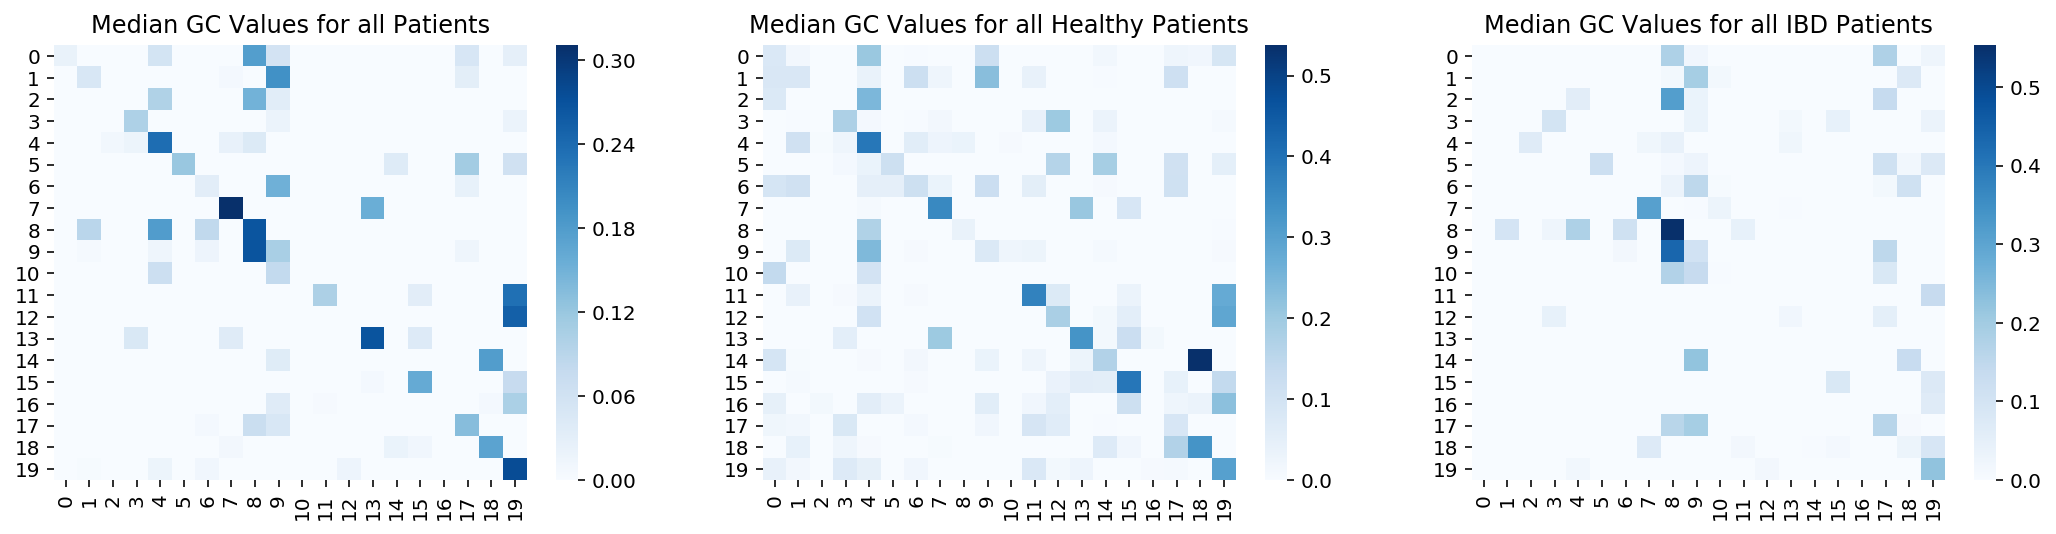

In [26]:
fig, axes = plt.subplots(ncols=3, figsize=(18,4))

sns.heatmap(np.median([heatmaps[i,-1] for i in range(9)], axis=0), ax=axes[0], cmap='Blues')
axes[0].set_title('Median GC Values for all Patients')

sns.heatmap(np.median([heatmaps[i,-1] for i in range(4)], axis=0), ax=axes[1], cmap='Blues')
axes[1].set_title('Median GC Values for all Healthy Patients')

sns.heatmap(np.median([heatmaps[i,-1] for i in range(4,9)], axis=0), ax=axes[2], cmap='Blues')
axes[2].set_title('Median GC Values for all IBD Patients')

plt.show()

Instead of looking at all interactions, and since some values are quite small, we can also consider the top 20 median values in each category.

In [27]:
def topk_median_indicators(heatmaps, k):
    median = np.median(heatmaps[:,-1], axis=0)
    return (median >= np.partition(median.reshape(-1), -k)[-k]).astype('float')

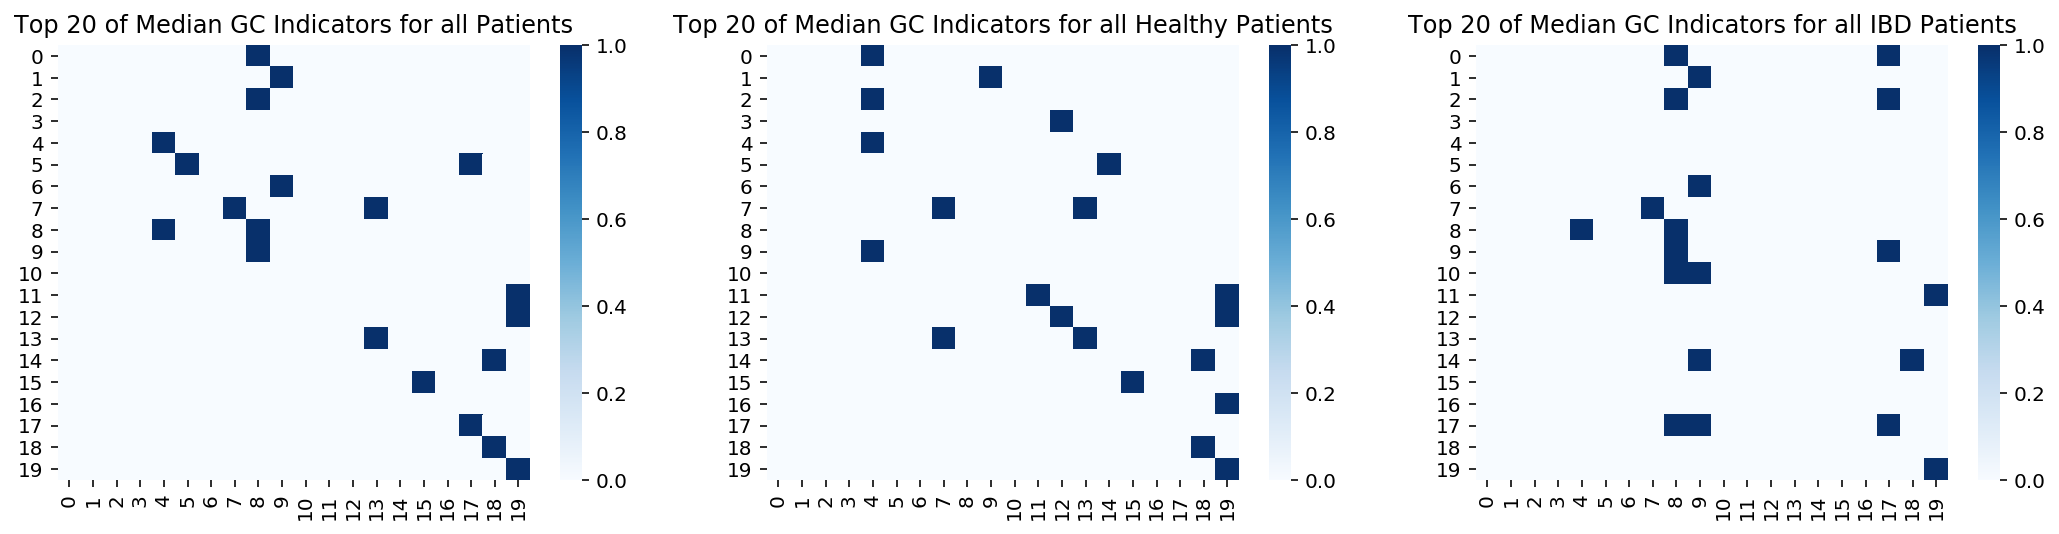

In [32]:
fig, axes = plt.subplots(ncols=3, figsize=(18,4))

sns.heatmap(topk_median_indicators(heatmaps, 20), cmap='Blues', ax=axes[0])
axes[0].set_title('Top 20 of Median GC Indicators for all Patients')

sns.heatmap(topk_median_indicators(heatmaps[:4], 20), cmap='Blues', ax=axes[1])
axes[1].set_title('Top 20 of Median GC Indicators for all Healthy Patients')

sns.heatmap(topk_median_indicators(heatmaps[4:], 20), cmap='Blues', ax=axes[2])
axes[2].set_title('Top 20 of Median GC Indicators for all IBD Patients')

plt.show()

### Pooling the Within-Experiment Mice <a name="pooling"></a>

When we think about the experiments at a high level, we realize that the mouse within the healthy group, and those separately in the IBD group, satisfy the property of *exchangeability* whereby we can permute their numbers and our beliefs about them should not change. In a typical Bayesian model, we may impose this through a hierarchical parameter-sharing construct. However, we instead simply take the mean of the time series within the healthy and IBD groups. This way we are reducing the within-group variance and pooling information.

In [54]:
import torch
from clstm import cLSTM, train_model_gista, train_model_adam

# For GPU acceleration
device = torch.device('cuda')

# Taking averages of Healthy and IBD Groups
top_reads=np.zeros_like(mice[2]['reads_standardized'][IMP_READS, :])

for mid in [2,3,4,5]: # healthy
    top_reads += mice[mid]['reads_standardized'][IMP_READS, :]
    
mean_reads_healthy = top_reads / 4
mean_reads_healthy = mean_reads_healthy.T

top_reads=np.zeros_like(mice[6]['reads_standardized'][IMP_READS, :])

for mid in [6,7,8,9,10]: # IBD
    top_reads += mice[mid]['reads_standardized'][IMP_READS, :]

mean_reads_IBD = top_reads / 5
mean_reads_IBD = mean_reads_IBD.T

X_torch_healthy = torch.tensor(mean_reads_healthy[np.newaxis], dtype=torch.float32, device=device)
X_torch_IBD = torch.tensor(mean_reads_IBD[np.newaxis], dtype=torch.float32, device=device)

These parameters were derived from our Bayesian Optimization procedure, so we use them. Here we **train the LSTM models with Adam**, and **no regularization on the Granger "causality" weights**. We will use these models later to investigate the difference this regularization makes on our predictions.

In [55]:
best_params={ 'lam_ridge': 0.00000316,
              'lam': 0.151,
              'lr': 0.00398,
              'n_hidden': 208,
              'truncation': 9,
              'max_iter': 2500
            }

In [59]:
from copy import deepcopy

p = len(IMP_READS)

healthy_pretrain = cLSTM(p, best_params['n_hidden']).cuda(device=device)
train_loss_healthy = train_model_adam(healthy_pretrain, X_torch_healthy, best_params['lr'], 500, 100, truncation=best_params['truncation'], verbose=2)

IBD_pretrain = cLSTM(p, best_params['n_hidden']).cuda(device=device)
train_loss_IBD = train_model_adam(IBD_pretrain, X_torch_IBD, best_params['lr'], 500, 100, truncation=best_params['truncation'], verbose=2)

----------Iter = 100----------
Loss = 0.027543
----------Iter = 200----------
Loss = 0.010021
----------Iter = 300----------
Loss = 0.002614
----------Iter = 400----------
Loss = 0.000587
----------Iter = 500----------
Loss = 0.000202
----------Iter = 100----------
Loss = 0.015830
----------Iter = 200----------
Loss = 0.004064
----------Iter = 300----------
Loss = 0.000898
----------Iter = 400----------
Loss = 0.000473
----------Iter = 500----------
Loss = 0.000121


**Training on Mean Healthy, Mean IBD with GISTA:**

We now use the mean time-series data from the healthy and IBD group to train a model with the Granger 'causality' penalty.

training on healthy
----------Iter = 500----------
Total loss = 2.904733
MSE = 0.295704, Ridge = 0.000002, Nonsmooth = 2.609027
Variable usage = 100.00%
----------Iter = 1000----------
Total loss = 1.994849
MSE = 0.262705, Ridge = 0.000004, Nonsmooth = 1.732140
Variable usage = 100.00%
----------Iter = 1500----------
Total loss = 1.132515
MSE = 0.258582, Ridge = 0.000005, Nonsmooth = 0.873929
Variable usage = 100.00%
----------Iter = 2000----------
Total loss = 0.438596
MSE = 0.284579, Ridge = 0.000006, Nonsmooth = 0.154011
Variable usage = 52.75%
----------Iter = 2500----------
Total loss = 0.390695
MSE = 0.290327, Ridge = 0.000008, Nonsmooth = 0.100361
Variable usage = 24.75%
training on IBD
----------Iter = 500----------
Total loss = 2.850675
MSE = 0.256196, Ridge = 0.000002, Nonsmooth = 2.594477
Variable usage = 100.00%
----------Iter = 1000----------
Total loss = 1.943397
MSE = 0.233078, Ridge = 0.000003, Nonsmooth = 1.710316
Variable usage = 100.00%
----------Iter = 1500---------

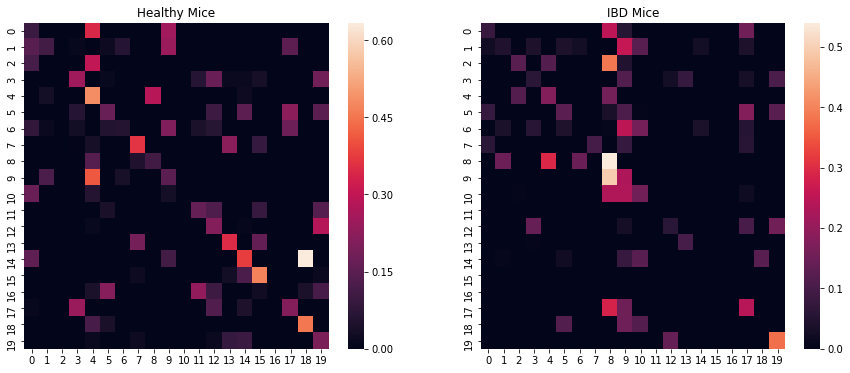

In [35]:
pretrained_models=[]
gc_models=[]
gc_matrices=[]

pretrain_eps=20
gc_eps=2500
check_every=500

top_reads=np.zeros_like(mice[2]['reads_standardized'][IMP_READS, :])

for mid in [2,3,4,5]: # healthy
    top_reads += mice[mid]['reads_standardized'][IMP_READS, :]
    
mean_reads_healthy = top_reads / 4
mean_reads_healthy = mean_reads_healthy.T

top_reads=np.zeros_like(mice[6]['reads_standardized'][IMP_READS, :])

for mid in [6,7,8,9,10]: # IBD
    top_reads += mice[mid]['reads_standardized'][IMP_READS, :]

mean_reads_IBD = top_reads / 5
mean_reads_IBD = mean_reads_IBD.T

X_torch_healthy = torch.tensor(mean_reads_healthy[np.newaxis], dtype=torch.float32, device=device)
X_torch_IBD = torch.tensor(mean_reads_IBD[np.newaxis], dtype=torch.float32, device=device)

# gc train on healthy
print('training on healthy')
healthy_model = cLSTM(p, best_params['n_hidden']).cuda(device=device)
train_loss_list, train_mse_list = train_model_gista(
  healthy_model, X_torch_healthy, lam=best_params['lam'], lam_ridge=best_params['lam_ridge'], 
  lr=best_params['lr'], truncation=best_params['truncation'], max_iter=gc_eps, check_every=check_every,
)

# gc train on IBDs
print('training on IBD')
IBD_model = cLSTM(p, best_params['n_hidden']).cuda(device=device)
train_loss_list, train_mse_list = train_model_gista(
  IBD_model, X_torch_IBD, lam=best_params['lam'], lam_ridge=best_params['lam_ridge'], 
  lr=best_params['lr'], truncation=best_params['truncation'], max_iter=gc_eps, check_every=check_every,
)

Above and below we see the same graph with just a different colormap. We are looking at the Granger causality weights for the top 20 bacteria.

#### Mean Causality Plots <a name="mean_causality"></a>

We see that the causality plots below closely resemble the plots from the individual mice training. This gives us some confidence that the relationships learned are valid.

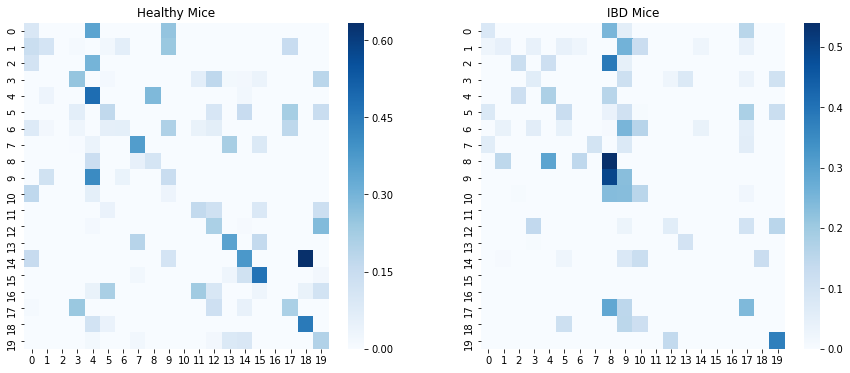

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_title('Healthy Mice')
sns.heatmap(healthy_model.GC(threshold=False).cpu().detach().numpy(), ax=ax[0], cmap='Blues')
ax[1].set_title('IBD Mice')
sns.heatmap(IBD_model.GC(threshold=False).cpu().cpu().detach().numpy(), ax=ax[1], cmap='Blues');

If one compares these plots to the ones found in the individual mice training, they show some very similar patterns.

In [40]:
GC_healthy = [torch.sum(net.lstm.weight_ih_l0, dim=0)
              for net in healthy_model.networks]
GC_healthy = torch.stack(GC_healthy)

GC_IBD = [torch.sum(net.lstm.weight_ih_l0, dim=0)
              for net in IBD_model.networks]
GC_IBD = torch.stack(GC_IBD)

Here, instead of taking the L2 norm of the weights, we take the sum instead to allow  negative values.

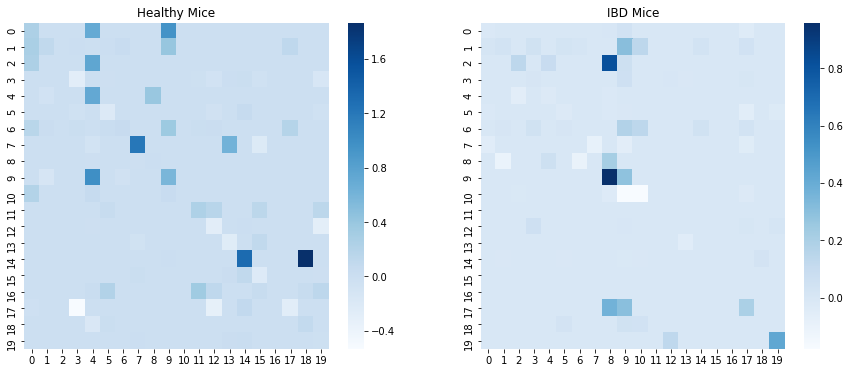

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_title('Healthy Mice')
sns.heatmap(GC_healthy.cpu().detach().numpy(), ax=ax[0], cmap='Blues')
ax[1].set_title('IBD Mice')
sns.heatmap(GC_IBD.cpu().detach().numpy(), ax=ax[1], cmap='Blues');

Now let's compare the preds from pre-training with these GISTA model preds.

In [60]:
# check preds
preds_healthy, hidden = healthy_pretrain(X_torch_healthy)
preds_IBD, hidden = IBD_pretrain(X_torch_IBD)

In [65]:
# check preds
preds_healthy_gista, hidden = healthy_model(X_torch_healthy)
preds_IBD_gista, hidden = IBD_model(X_torch_IBD)

#### Mean Predictions: Adam vs GISTA <a name="mean_preds"></a>

Here we look at the healthy mice, comparing the predictions for the mean time-series from the Adam model (no causality regularization) and the GISTA training (with causality). First we look at the top 20 bugs for the healthy mice.

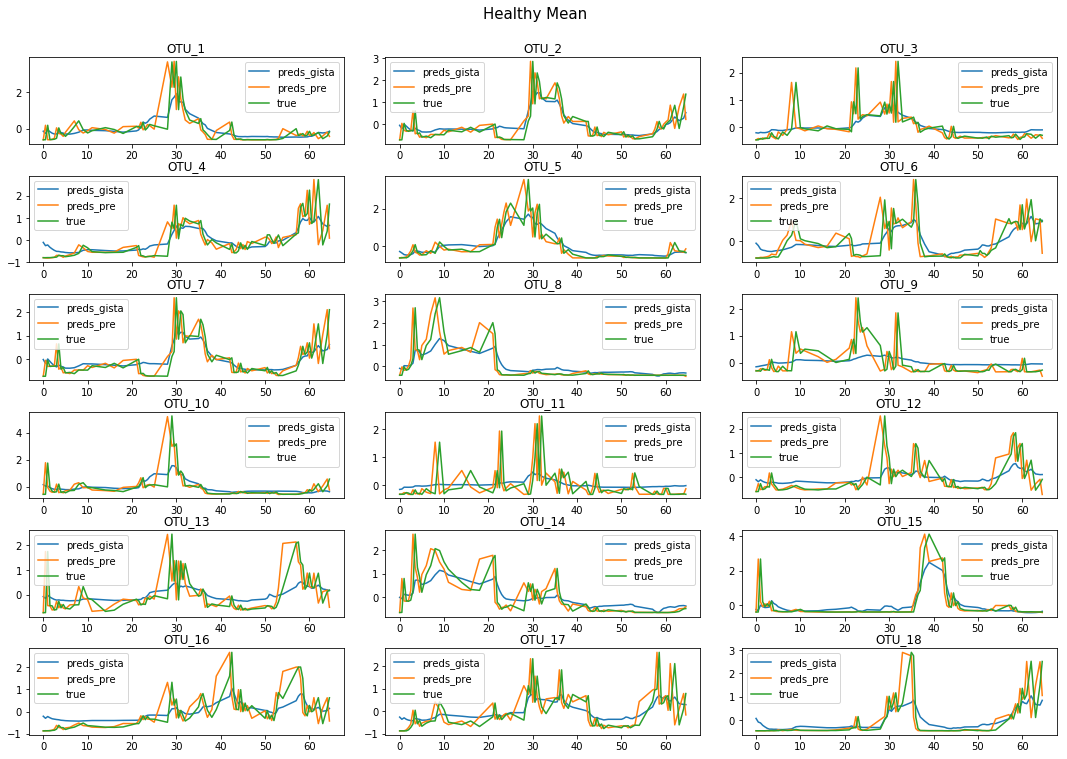

In [67]:
fig, ax = plt.subplots(p//3, 3, figsize=(15,10))
fig.tight_layout()
fig.suptitle('Healthy Mean', y=1.05, fontsize=15)
ax = ax.ravel()
for i in range(p):
    if i > len(ax) - 1:
        breaks

    ax[i].plot(mouse2_t, preds_healthy_gista[0,:,i].cpu().detach().numpy(), label='preds_gista')
    ax[i].plot(mouse2_t, preds_healthy[0,:,i].cpu().detach().numpy(), label='preds_pre')
    ax[i].plot(mouse2_t, mean_reads_healthy[:,i], label='true')
    ax[i].legend()
    ax[i].set_title('{}'.format(mouse2_otu[i]))

Now we look at the IBD mice.

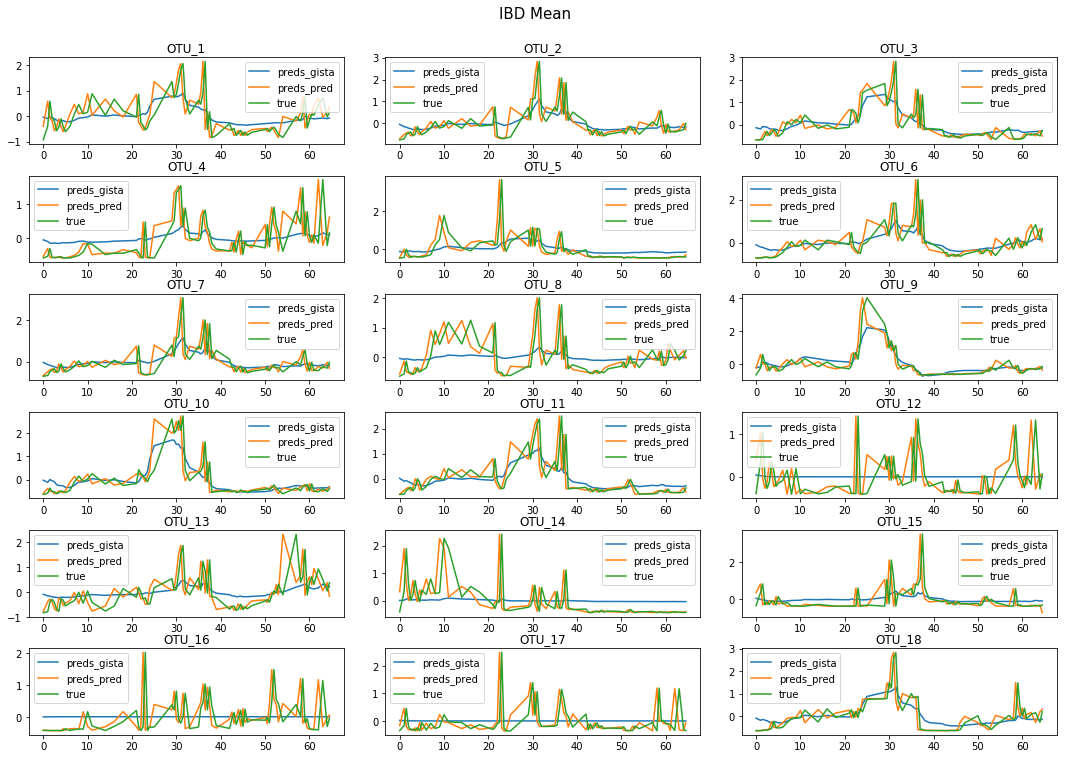

In [69]:
fig, ax = plt.subplots(p//3, 3, figsize=(15,10))
fig.tight_layout()
fig.suptitle('IBD Mean', y=1.05, fontsize=15)
ax = ax.ravel()

mouse6_t = mice[6]['times']
mouse6_otu = mice[6]['otus']

for i in range(p):
    if i > len(ax) - 1:
        break

    ax[i].plot(mouse6_t, preds_IBD_gista[0,:,i].cpu().detach().numpy(), label='preds_gista')
    ax[i].plot(mouse6_t, preds_IBD[0,:,i].cpu().detach().numpy(), label='preds_pred')
    ax[i].plot(mouse6_t, mean_reads_IBD[:,i], label='true')
    ax[i].legend()
    ax[i].set_title('{}'.format(mouse6_otu[i]))

We see what we expect: the blue line, which represents the predictions from the GISTA-trained models, are smoothed out due to the penalty imposed on the input layer of the network (the layer which allows information to flow between time series). 

## Conclusion <a name="conclusion"></a>

By analyszing the time series of the several OTUs, we showed similar dynamics for each individual mouse'microbiome. Moreover, the analysis of healthy and IBD mice showed striking differences in dynamics. The sick mice have a weaker biodiversity and OTU presence than the healthy mice, as well as different causality relations within the most prevalent bugs.
For this work, we used primarily the Granger Causality analysis as well as customized Deep Reccurent Networks, the cLSTM. The advantage of these models is that they induce sparsity and regularization. Also, they enable the visualization of interactions between bugs that allows interpretability
